<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:28px; ">
  <p style=" text-align: center; font-size: 32px;">   
   <strong>Momentum Strategies on S&P 500 Sector Indices </strong></p>
    <p style=" text-align: center; font-size: 25px;"><strong> Master Probabilities & Finance - Ecole Polytechnique and Sorbonne University <strong></p>
  <p style=" text-align: center; font-size: 20px;"> Constantin GLEYZE, Williams DJAFRI</p>
</header>

## Momentum Strategy Overview – Technical Summary (I.1 & III.1 of our analysis)

This notebook implements a family of momentum strategies inspired by Jegadeesh & Titman (1993), applied to S&P 500 sector indices.

> **Reference paper:**  
> Jegadeesh, N., & Titman, S. (1993). *Returns to Buying Winners and Selling Losers: Implications for Stock Market Efficiency*. Journal of Finance, 48(1), 65–91.


---

### 1. Reference Model – J/K Momentum Strategy

- **Strategy logic**: At time t, rank assets by cumulative return over the past **J months**.
- **Portfolio**:
  - Long: Top decile (winners)
  - Short: Bottom decile (losers)
  - Equal-weighted within legs
- **Holding period**: K months.
- **Monthly rebalancing**: Each month a new J/K portfolio is formed; previous portfolios are retained until expiration.
- **Overlap**: Up to K active portfolios at any time (rolling window).
- **Lag**: 1-week lag between signal and execution in original paper (to mitigate bid-ask bounce); omitted here.

---

### 2. Implementation Scope (Section III.1 of our analysis)

#### 2.1 Universe

- 24 sector indices of the S&P 500
- Historical period: **1989-10-02 to 2018-01-29**
- **Data frequency**: Monthly closing prices (last trading day of each month)
- Returns and rebalancing computed on a **monthly basis**
- Effective backtest range: varies by J (i.e J=24 → starts in 1991)

#### 2.2 Strategy Grid

- Tested configurations: 14 J/K pairs: [3/1, 3/3, 3/6, 3/9, 3/12, 6/3, 6/6, 6/12, 9/6, 9/9, 12/6, 12/12, 24/12, 24/24]


#### 2.3 Portfolio Logic

- **Long-only**: Top 5 sectors by J-month return.
- **Long-short**: Long top 5 / Short bottom 3 sectors.
- **Capital neutrality**: 100% nominal in long and short legs.
- **Rebalancing**: Monthly, at fixed calendar frequency.
- **Granularity**: Partial allocation allowed (infinitesimal reweighting supported).

#### 2.4 Weighting Schemes

- **EW**: Equal weights across sub-portfolios and sub-indices.
- **IW**: Weighted by cumulative return since sub-portfolio inception (zeros truncated).
- **IRW**: Same as IW, but last 3-month return used (short-term winners only).
- **FD**: Full capital directional switch based on benchmark momentum:
    - ↑ Market → Fully long
    - ↓ Market → Fully short
    - Flat → 50/50
    - Allocation within legs uses last 1-month return.

---

### 3. Transaction Cost Models

1. **Zero cost**: Baseline scenario.
2. **Linear cost**:
 - Long trades: 50 bps
 - Short trades: 65 bps (borrowing + liquidity cost)
3. **Dynamic cost**:
 - Fixed floor: 10 bps
 - Tiered scale (per trade):
   ```
   > $20M: +100 bps
   > $10M: +75 bps
   > $5M:  +40 bps
   $1M–5M: from 20 to 5 bps
   < $1M: no additional fees
   ```
 - Applied symmetrically to long and short trades.

---

### 4. Performance Metrics

- Total Return (Cash-on-Cash)
- Monthly Average Return
- Annualized Volatility (σ)
- Unadjusted Sharpe Ratio (μ/σ), r_f = 0
- Max Drawdown (peak-to-trough loss)
- Average Drawdown (mean drawdown over periods)
- Monthly Avg. Turnover (% of portfolio nominal)
- Monthly Avg. Transaction Costs (% of nominal)

---

### 5. Modeling & Data Assumptions

- Initial allocation is treated as **100% turnover**, in line with how transaction costs are applied.
- No leverage, margin, or financing costs are assumed.
- Strategies are **unweighted relative to SPX composition** — no use of sector weights due to static or undated weight issues in the dataset.
- **Start dates are staggered**: no portfolio is built until the full lookback window J is available for a given strategy.
- The dataset is filtered to ensure consistent monthly returns:
  - **September 1989** is excluded due to partial data.
  - **January 2018** is retained as a full month (despite being incomplete), as last-day data is available.
- Monthly returns are based on **end-of-month closing prices**, using the last available trading day of each calendar month.
- All strategies are evaluated under **identical calendar alignment, rebalancing logic**, and **data window**, ensuring comparability across configurations.

In [1]:
import pandas as pd 
import math
import numpy as np
from collections import deque
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from IPython.display import display, HTML

In [ ]:
file_path = r"Data SP500.xlsx"

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">Intro : Import data</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [2]:
import pandas as pd

def extract_data_from_excel(file_path):
    """
    Extracts data from an Excel file containing financial indices and their weights.

    The function:
    - Loads the Excel file.
    - Extracts the "Poids" sheet containing weights.
    - Extracts the "Données" sheet without headers (to be handled manually).
    - Retrieves index names from the first row.
    - Processes the data in pairs of columns to extract index data.

    Parameters:
    - file_path (str): Path to the Excel file.

    Returns:
    - df_poids (pd.DataFrame): DataFrame containing weights from the "Poids" sheet.
    - dataframes (dict): Dictionary mapping index names to their respective time series DataFrames.
    """
    # Load the Excel file
    xls = pd.ExcelFile(file_path)

    # Extract the "Poids" sheet containing index weights
    df_poids = pd.read_excel(xls, sheet_name="Poids")

    # Load the "Données" sheet without specifying a header (handled manually)
    df_donnees = pd.read_excel(xls, sheet_name="Données", header=None, na_values="#N/A N/A")

    # Store extracted DataFrames in a dictionary
    indices_noms = df_donnees.iloc[0]

    # Store extracted DataFrames in a dictionary
    dataframes = {}

    # Iterate over columns in steps of three to extract indices
    for col in range(0, df_donnees.shape[1], 3):  # Skip 3 columns to ignore the str values within the excel
        if pd.isna(indices_noms[col]):
            continue  # Skip empty columns (between each series)
            
        # Retrieve the index name
        nom_indice = indices_noms[col] 
        date_col = col
        px_last_col = col + 1

        # Ensure the column index is within bounds
        if px_last_col >= df_donnees.shape[1]:
            continue

        # Extract data associated with this index
        df_sub = df_donnees.iloc[2:, [date_col, px_last_col]].copy()  # À partir de la 3e ligne

        # Rename columns for clarity
        df_sub.columns = ["Date", "PX_LAST"]

        # Convert "Date" column to datetime format and set it as index
        df_sub["Date"] = pd.to_datetime(df_sub["Date"], errors='coerce')
        df_sub.set_index("Date", inplace=True)

        # Add to the dictionary
        dataframes[nom_indice] = df_sub

    return df_poids, dataframes

# Usage - Specify your specific path
df_poids, dataframes = extract_data_from_excel(file_path)

<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:20px; ">
  <p style=" text-align: center; font-size: 32px;">   
    <p style=" text-align: center; font-size: 33px;"><strong> 1. Implementation of the strategies <strong></p>
</header>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">1.1. External minor functions used in the classes</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [3]:
def filter_complete_months(dfs_dict):
    """
    Filters out incomplete months and selects specific dates:
    - Retains only the first business day of the first kept month.
    - For all subsequent months, retains only the last available day.

    Steps:
    - Identifies the first and last months in the dataset.
    - Checks if these months have at least 28 days (ensuring completeness).
    - Removes the first and last months if incomplete.
    - Identifies the first business day of the first retained month.
    - Extracts the last available date for each subsequent month.
    - Filters each DataFrame to retain only the selected dates.

    Parameters:
    - dfs_dict (dict): Dictionary containing DataFrames with time series data.

    Returns:
    - filtered_dfs (dict): Dictionary with DataFrames containing only the selected dates.
    """

    # Select the benchmark (first df) to determine date range
    df_reference = list(dfs_dict.values())[0]
    dates = df_reference.index

    # Identify the first and last months in the dataset
    first_month = dates.min().to_period('M')
    last_month = dates.max().to_period('M')

    # Check if the first month is complete
    first_month_dates = dates[dates.to_period('M') == first_month]
    first_month_complete = first_month_dates.min().day == 1 and first_month_dates.max().day >= 28

    # Check if the last month is complete
    last_month_dates = dates[dates.to_period('M') == last_month]
    last_month_complete = last_month_dates.min().day == 1 and last_month_dates.max().day >= 28

    # Remove incomplete first or last months
    if not first_month_complete:
        dates = dates[dates.to_period('M') != first_month]
    if not last_month_complete:
        dates = dates[dates.to_period('M') != last_month]

    unique_months = dates.to_period('M').unique() # Get the list of unique months in the filtered dataset

    # Identify the first business day of the first kept month
    first_kept_month = unique_months[0]
    first_business_day = dates[dates.to_period('M') == first_kept_month].min()
    
    # Identify the first business day of the first kept month
    last_days = dates.to_series().groupby(dates.to_period('M')).max()
    
    # Construct the final list of selected dates
    selected_dates = [first_business_day] + list(last_days)

    # Filter each DataFrame to retain only the selected dates
    filtered_dfs = {key: df.loc[df.index.intersection(selected_dates)] for key, df in dfs_dict.items()}
  
    return filtered_dfs

def compute_betas (datas): 
    """
    Computes the beta values for each index relative to the benchmark.

    Beta measures an asset's sensitivity to movements in the benchmark index.
    It is calculated as the covariance of the asset returns with the benchmark returns
    divided by the variance of the benchmark returns.

    Steps:
    - Selects the first dataset in the dictionary as the benchmark.
    - Converts the "PX_LAST" column to numeric format.
    - Computes log returns for the benchmark.
    - Computes log returns for each index in the dataset.
    - Uses covariance and variance to calculate beta values.

    Parameters:
    - datas (dict): Dictionary containing financial time series DataFrames.

    Returns:
    - betas (dict): Dictionary mapping index names to their beta values.
    """
    
    # Select the benchmark (first entry in the dictionary)
    benchmark_name, benchmark_data = next(iter(dataframes.items()))
    benchmark_data["PX_LAST"] = pd.to_numeric(benchmark_data["PX_LAST"], errors='coerce')

    # Compute log returns for the benchmark
    benchmark_prices = benchmark_data["PX_LAST"]
    benchmark_returns = np.log(benchmark_prices / benchmark_prices.shift(1))

    # Compute log returns for each index (excluding the benchmark)
    price_df = {name: np.log(pd.to_numeric(df["PX_LAST"], errors='coerce') / pd.to_numeric(df["PX_LAST"], errors='coerce').shift(1))
    for name, df in dataframes.items() if name != benchmark_name and "PX_LAST" in df.columns}

    # Compute beta for each index
    betas = {}
    for name, returns in price_df.items() : 
        first_date = returns.first_valid_index() # Identify the first valid date for the index
        valid_benchmark = benchmark_returns.loc[first_date:]  # Align benchmark and subindex returns based on this date
        valid_subindex = returns.loc[first_date:]
        covar = np.cov(valid_benchmark, valid_subindex,ddof=0)[0, 1] # Compute covariance between the index and benchmark
        var = np.var(valid_benchmark,ddof=0)
        betas[name] = covar / var # Calculate beta as cov(X, Y) / var(X)

    return betas 

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">1.2. Classes strategy & BackTest strategy objects</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [4]:
class strategy : 
    """
    Implements an investment strategy (rebalancing ) with long and short positions,
    transaction costs, and specific observation and holding periods.

    This strategy selects a predefined number of long and short positions 
    based on a given weighting function.

    Attributes:
    - transaction_costs (function): Function to determine costs incurred during the rebalancing of an subindex.
    - get_ponderation (function): Function that determines asset weights in the portfolio.
    - long_fees (float): Fees applied to long positions.
    - short_fees (float): Fees applied to short positions.
    - observ_period (int): Observation period used for strategy evaluation.
    - holding_period (int): Holding period before rebalancing.
    - nb_short (int): Number of short positions in the strategy.
    - nb_long (int): Number of long positions in the strategy.
    """
    
    def __init__(self, transaction_costs, get_ponderation, long_fees, short_fees, observ_period, holding_period, nb_short, nb_long):
        
        self.long_fees = long_fees
        self.short_fees = short_fees
        self.observ_period = observ_period
        self.holding_period = holding_period
        self.transaction_costs = transaction_costs
        self.get_ponderation = get_ponderation  
        self.nb_short = nb_short
        self.nb_long = nb_long

class StrategyBacktest : 
    """
    Implements a backtesting framework for an investment strategy.

    This class allows for historical testing of a strategy on the data.

    Attributes:
    - index_ponderation (pd.DataFrame): DataFrame containing index weightings.
    - datas (dict): Dictionary of DataFrames containing historical market data.
    """
    
    def __init__ (self, index_ponderation, datas): 
        self.index_ponderation=index_ponderation # dataframe
        self.datas=datas # list of dataframe

    def recenter_period (self,period): 
        """
        Filters historical data to keep only observations within a specified time period.

        Parameters:
        - period (tuple of str): A tuple (start_date, end_date) with date strings in format 'YYYY-MM-DD'.

        Returns:
        - datas_filtered (dict): Dictionary of DataFrames filtered within the specified period.
        """

        start_date, end_date = pd.to_datetime(period) # Convert input period (start_date, end_date) to datetime format
        
        # Filter each DataFrame to keep only data within the given period
        datas_filtered = {name: data[(data["Date"] >= start_date) & (data["Date"] <= end_date)]for name, data in self.datas.items()}
        return datas_filtered
    
    def get_perf(self,datas_monthly, start_idx,end_idx,nb_short,nb_long): 
        """
        Computes asset performances over a given period and selects the best and worst performers.
        
        Steps:
        - Computes performance as the percentage price change from start to end index.
        - Filters out assets with missing start or end prices.
        - Determines the number of short and long positions if given as a fraction.
        - Sorts subindex based on their performance.
        - Selects the top performers for long positions and the bottom performers for short positions.
        
        Parameters:
        - datas_monthly (dict): Dictionary where keys are subindex names and values are DataFrames with monthly data.
        - start_idx (int): Index corresponding to the start of the observation period.
        - end_idx (int): Index corresponding to the end of the observation period.
        - nb_short (int or float): Number of short positions (or fraction of total assets).
        - nb_long (int or float): Number of long positions (or fraction of total assets).
        
        Returns:
        - top_dict (dict): Empty dictionary of top-performing assets (new long positions).
        - bottom_dict (dict): Empty dictionary of worst-performing assets (new short positions).
        """
        
        performances = {} # Dictionary to store asset performances

        # Iterate over each asset to compute its performance on the given observation period
        for name, data in datas_monthly.items():
            start_price = data.iloc[start_idx]["PX_LAST"]
            end_price = data.iloc[end_idx]["PX_LAST"]
            
            # Skip assets with missing prices
            if pd.isna(start_price) or pd.isna(end_price):
                continue

            # Compute performance over the observation period
            perf = (end_price - start_price)/start_price  # Performance sur `observ_period` mois
            performances[name] = perf

        # If nb_short or nb_long is given as a fraction, convert to absolute number of assets
        if nb_short < 1 : 
            nb_short = math.ceil((len(datas_monthly)-1)*nb_short)

        if nb_long < 1 : 
            nb_long = math.ceil((len(datas_monthly)-1)*nb_long)

        sorted_perfs = sorted(performances.items(), key=lambda x: x[1], reverse=True) # Sort assets by performance in descending order
        top_dict = {name: [perf, []] for name, perf in sorted_perfs[:nb_long]} # Select the top-performing assets for long positions
        bottom_dict = {name: [perf, []] for name, perf in sorted_perfs[-nb_short:]} # Select the worst-performing assets for short positions
    
        return top_dict, bottom_dict

    def maj_current_pf (self,datas_monthly,current_long_portfolio,current_short_portfolio,j):
        """
        Updates the current portfolios (long and short) based on monthly performance.
        
        This function:
        - Iterates over all subindices in the long and short portfolios.
        - Computes the monthly performance for each subindex.
        - Updates the stored performance history.
        - Adjusts the portfolio value accordingly.
        
        Parameters:
        - datas_monthly (dict): Dictionary containing historical price data for each subindex.
        - current_long_portfolio (list of dict): List of dictionaries representing long subportflios.
        - current_short_portfolio (list of dict): List of dictionaries representing short subportflios.
        - j (int): Index of the current month in the dataset.
        
        Returns:
        - current_long_portfolio (list of dict): Updated long portfolio with new performance values.
        - current_short_portfolio (list of dict): Updated short portfolio with new performance values.
        """

        # Update long positions based on monthly performance
        for pf_dict in current_long_portfolio:
            for name in pf_dict.keys():
                # Compute monthly performance for the subindex
                perf = (datas_monthly[name]["PX_LAST"].iloc[j] - datas_monthly[name]["PX_LAST"].iloc[j-1]) / datas_monthly[name]["PX_LAST"].iloc[j-1]
                pf_dict[name][0] *= (1 + perf)  # Update portfolio value and store the performance history
                pf_dict[name][1].append(perf)

         # Update short positions based on monthly performance (negative exposure)
        for pf_dict in current_short_portfolio:
            for name in pf_dict.keys():
                # Compute monthly performance for the subindex (negated for short positions)
                perf = -((datas_monthly[name]["PX_LAST"].iloc[j] - datas_monthly[name]["PX_LAST"].iloc[j-1]) / datas_monthly[name]["PX_LAST"].iloc[j-1])
                pf_dict[name][0] *= (1 + perf) # Update portfolio value and store the performance history
                pf_dict[name][1].append(perf)
                
        return current_long_portfolio,current_short_portfolio
        
    def get_nominal_value(self,pf_of_pf): 
        """
        Computes the total nominal value of the portfolio.
        
        This function:
        - Iterates over all subportfolios in the portfolio.
        - Sums up the first value (nominal value) from each subindex.
        
        Parameters:
        - pf_of_pf (list of dict): Portfolio containing multiple subportfolios.
        
        Returns:
        - float: Total nominal value of the portfolio.
        """
        
        # Check if all elements are dictionaries (subportfolios)
        for d in pf_of_pf:
            if not isinstance(d, dict):
                print(f"Error : An element of the portfolio to be computed is not a dict: {type(d)} → {d}")
                
        # Sum the nominal values from all subportfolios
        return sum(v[0] for d in pf_of_pf for v in d.values() if isinstance(v, list) and isinstance(v[0], float))

    def get_beta (self, betas, pfs): 
        """
        Computes the overall beta of the portfolio based on the weighted betas of subindices.
        
        This function:
        - Retrieves the total nominal value of the portfolio.
        - Iterates through each subportfolio.
        - Weighs each subindex's beta by its nominal proportion in the portfolio.
        - Computes the final aggregated beta.
        
        Parameters:
        - betas (dict): Dictionary containing the beta values of all subindices.
        - pfs (list of dict): Portfolio containing multiple subportfolios.
        
        Returns:
        - float: The overall beta of the portfolio.
        """
        
        beta = 0
        value = self.get_nominal_value (pfs) # Get the total nominal value of the portfolio

        # Compute weighted beta across all subportfolios
        for pf in pfs : 
            for name, content in pf.items(): # Iterate over subindices in the subportfolio
                beta+= (content[0]/value)*betas[name] # Weighted beta contribution
        return beta

    def update_pf (self,pfs, pf_nominal,weights_pf,weight_intra_pf,transaction_costs,fees):
        """
        Updates the portfolio based on rebalancing instructions (global and local weights).
    
        This function:
        - Adjusts each subportfolio's allocation based on global and local weights.
        - Computes the difference (delta) between current and target allocation.
        - Applies transaction costs for adjustments if the position is not fully liquidated.
        - Store fees not deducted when fully liquidating a position.
        - Returns the updated portfolio along with total costs and remaining fees.
    
        Parameters:
        - pfs (list of dict): Portfolio containing multiple subportfolios.
        - pf_nominal (float): Total nominal value of the portfolio.
        - weights_pf (list of float): Global weights assigned to each subportfolio.
        - weight_intra_pf (list of dict): Dictionary of local weights within each subportfolio.
        - transaction_costs (function): Function to compute transaction costs.
        - fees (float): Fees stocked when liquidating positions.
    
        Returns:
        - total_cost (float): Total transaction costs incurred.
        - pfs (list of dict): Updated portfolio after rebalancing.
        - total_value_to_obtain (float): Net amount of value adjustments applied to compute the turnover.
        - fees_to_deduce (float): Remaining fees for fully liquidated positions.
        """

        total_cost = 0 # Tracks total transaction costs
        total_value_to_obtain = 0 # Tracks total adjustments in value
        fees_to_deduce = 0 # Tracks fees for liquidated positions

        # Iterate through each subportfolio
        for i, pf_dict in enumerate(pfs):
            global_weight = weights_pf[i] # Weight assigned to this subportfolio
            local_weights = weight_intra_pf[i] # Local weights for subindices within the subportfolio
            allocation_to_pf = pf_nominal*global_weight # Nominal amount allocated to this subportfolio

            # Iterate through each subindex in the subportfolio
            for component_name, local_weight in local_weights.items():
                value_to_obtain = local_weight*allocation_to_pf # Target value for this subindex
                delta = value_to_obtain - pf_dict[component_name][0] # Difference to adjust
                total_value_to_obtain+=delta # Accumulate total value adjustments to compute the turnover
                partial_cost = transaction_costs(delta, fees) # Compute transaction costs

                # If the position is fully liquidated, reset value and store the fee to be deducted
                if value_to_obtain == 0 : 
                    pf_dict[component_name][0] = 0 
                    fees_to_deduce+=partial_cost
                else : 
                    # Update the subindex value after accounting for transaction costs
                    pf_dict[component_name][0] = pf_dict[component_name][0] + delta - partial_cost
                total_cost+=partial_cost # Accumulate transaction costs

        return total_cost,pfs,total_value_to_obtain,fees_to_deduce

    def share_uniformously(self,pfs_long,pfs_short,fees_to_deduce):
        """
        Distributes remaining fees that couldn't be deducted after liquidating a position.
    
        This function:
        - Counts the number of subindices in both long and short subportfolios that can cover the fees.
        - Computes the share of fees each qualifying subindex should pay.
        - Deducts the calculated fee share from each qualifying subindex.
    
        Parameters:
        - pfs_long (list of dict): List of long subportfolios.
        - pfs_short (list of dict): List of short subportfolios.
        - fees_to_deduce (float): Remaining fees to be distributed across the portfolio.
    
        Returns:
        - pfs_long (list of dict): Updated long subportfolios after fee deduction.
        - pfs_short (list of dict): Updated short subportfolios after fee deduction.
        """

        # Count subindices that can cover the fees
        count_positive = sum(1 for pf in pfs_long  for name in pf if pf[name][0] >= fees_to_deduce)
        count_positive += sum(1 for pf in pfs_short  for name in pf if pf[name][0] >= fees_to_deduce)
        fees_to_share = fees_to_deduce/count_positive # Compute the fee share for each qualifying subindex


        # If no subindex can cover the fees, return the portfolios unchanged (not enough money at all the difference would not change the appreciation of the strategy)
        if count_positive == 0:
            return pfs_long,pfs_short
        else : 
            # Deduct the shared fee amount from each qualifying subindex
            for pf in pfs_long: 
                for name in pf:
                    if pf[name][0] >= fees_to_deduce:
                        pf[name][0] -= fees_to_share  # Deduct the fee share

            for pf in pfs_short:
                for name in pf:
                    if pf[name][0] >= fees_to_deduce:
                        pf[name][0] -= fees_to_share # Deduct the fee share
            return pfs_long,pfs_short
              
    def apply_ponderation(self,pfs_long,pfs_short, new_pf_long,new_pf_short, get_ponderation,transaction_costs, lost_last, long_fees,short_fees,specific_treatment,benchmark_performance):
        
        """
        Applies new weightings to the portfolio, updating subportfolios while managing constraints.
    
        This function:
        - Handles cases where subportfolio limits are reached (`lost_last` → oldest subportfolio is liquidated).
        - Manages a special case (`specific_treatment` → allows only one subportfolio, forcing systematic liquidation).
        - Allocates the new subportfolios (`new_pf_long` and `new_pf_short`) according to computed weightings.
        - Updates remaining subportfolios in the portfolio after adding new allocations.
        - Computes total transaction costs and turnover.
    
        Parameters:
        - pfs_long (deque of dict): Current long subportfolios.
        - pfs_short (deque of dict): Current short subportfolios.
        - new_pf_long (dict): New long subportfolio to be added.
        - new_pf_short (dict): New short subportfolio to be added.
        - get_ponderation (function): Function that determines weight allocation.
        - transaction_costs (function): Function that computes transaction costs.
        - lost_last (bool): If `True`, the oldest subportfolio is removed before adding a new one.
        - long_fees (float): Transaction fees for long positions.
        - short_fees (float): Transaction fees for short positions.
        - specific_treatment (bool): If `True`, only one subportfolio is allowed, forcing systematic liquidation.
        - benchmark_performance (float): Performance of the benchmark for allocation adjustments.
    
        Returns:
        - total_cost (float): Total transaction costs incurred.
        - pfs_long (deque of dict): Updated long subportfolios.
        - pfs_short (deque of dict): Updated short subportfolios.
        - long_short_alloc (tuple): Allocated weights for long and short positions.
        - turnover (float): Turnover ratio after rebalancing.
        """
        
        total_cost = 0
        turnover_amount = 0 
        partial_cost = 0 
        fees_to_deduce = 0

        ### SPECIAL CASE: SYSTEMATIC LIQUIDATION ###
        if specific_treatment : 
            total_cost = 0 

            # Compute total liquidation cost
            for name, pf in pfs_long[0].items(): 
                total_cost+=transaction_costs(pfs_long[0][name][0], long_fees) #ICI GPT A REGARDER
            for name, pf in pfs_short[0].items(): 
                total_cost+=transaction_costs(pfs_short[0][name][0], short_fees)

            # Compute remaining value after liquidation (post transaction costs)
            liquidation_value = self.get_nominal_value([pfs_long[0]])+self.get_nominal_value([pfs_short[0]]) - total_cost

            # Remove the only allowed subportfolio
            pfs_long.popleft()
            pfs_short.popleft

            # Compute new allocation
            long_short_alloc, long_ponderation,short_ponderation = get_ponderation(None, None, new_pf_long,new_pf_short,self.index_ponderation,benchmark_performance)

            # Allocate new long subportfolio
            for component_name, local_weight in long_ponderation.items():
                value_to_obtain = local_weight*liquidation_value*long_short_alloc[0]
                partial_cost = transaction_costs(value_to_obtain, long_fees)
                new_pf_long[component_name][0] = value_to_obtain - partial_cost
                total_cost+=partial_cost
                
            # Allocate new short subportfolio
            for component_name, local_weight in short_ponderation.items():
                value_to_obtain = local_weight*liquidation_value*long_short_alloc[-1]
                partial_cost = transaction_costs(value_to_obtain, short_fees)
                new_pf_short[component_name][0] = value_to_obtain - partial_cost
                total_cost+=partial_cost
                
            return total_cost,deque([new_pf_long]), deque([new_pf_short]),long_short_alloc,1 # We return 1 for a systematic 100% turnover

        ### STANDARD CASE: SUBPORTFOLIO ROLLING ###  
        if lost_last : 

            # Compute total portfolio value before liquidation for the turnover
            old_total_value = self.get_nominal_value(pfs_long)+self.get_nominal_value(pfs_short)

            # Compute liquidation cost
            partial_cost += transaction_costs(self.get_nominal_value([pfs_long[0]]), long_fees)
            partial_cost += transaction_costs(self.get_nominal_value([pfs_short[0]]), short_fees)
            
            # Compute remaining value after liquidation
            liquidation_value = self.get_nominal_value([pfs_long[0]])+self.get_nominal_value([pfs_short[0]]) - partial_cost

            # Remove the oldest subportfolio
            pfs_long.popleft()
            pfs_short.popleft()

            # Compute new total value after rebalancing
            total_value = self.get_nominal_value(pfs_long) +self.get_nominal_value(pfs_short) + liquidation_value
            total_cost+=partial_cost
        else : 
            # We have no rolling so we just stock the portfolio's value for the turnover
            total_value = self.get_nominal_value(pfs_long) +self.get_nominal_value(pfs_short) 
            old_total_value = total_value

        # Compute new allocation weights
        long_short_alloc,new_pf_ponderation, new_pf_local_ponderation = get_ponderation(pfs_long,pfs_short, new_pf_long,new_pf_short,self.index_ponderation,benchmark_performance)
        nominal_long_portfolio = long_short_alloc[0]*total_value
        nominal_short_portfolio = long_short_alloc[-1]*total_value

        # Compute nominal allocation values for long and short portfolios
        alloc_new_pf_long = new_pf_ponderation[0][-1]*nominal_long_portfolio
        local_weights_long_new_pf = new_pf_local_ponderation[0][-1]

        # Allocate new long subportfolio
        for component_name, local_weight in local_weights_long_new_pf.items():
            value_to_obtain = local_weight*alloc_new_pf_long
            turnover_amount+=value_to_obtain
            partial_cost = transaction_costs(value_to_obtain,long_fees)
            new_pf_long[component_name][0] = value_to_obtain - partial_cost
            total_cost+=partial_cost

        # Allocate new short subportfolio
        alloc_new_pf_short = new_pf_ponderation[-1][-1]*nominal_short_portfolio
        local_weights_short_new_pf = new_pf_local_ponderation[-1][-1]
        for component_name, local_weight in local_weights_short_new_pf.items():
            value_to_obtain = local_weight*alloc_new_pf_short
            turnover_amount+=value_to_obtain
            partial_cost = transaction_costs(value_to_obtain,short_fees)
            new_pf_short[component_name][0] = value_to_obtain - partial_cost
            total_cost+=partial_cost

        # Update existing subportfolios
        costs_long, pfs_long, value_to_obtain_long,fees_to_deduce_long =self.update_pf(pfs_long, nominal_long_portfolio, new_pf_ponderation[0], new_pf_local_ponderation[0],transaction_costs,long_fees) 
        pfs_long.append(new_pf_long)
        costs_short, pfs_short,value_to_obtain_short,fees_to_deduce_short =self.update_pf(pfs_short, nominal_short_portfolio, new_pf_ponderation[-1], new_pf_local_ponderation[-1],transaction_costs,short_fees) 
        pfs_short.append(new_pf_short)

        # Compute total costs and turnover
        total_cost += costs_long + costs_short
        turnover_amount+=value_to_obtain_long+value_to_obtain_short
        turnover = turnover_amount/old_total_value
        fees_to_deduce+=fees_to_deduce_long+fees_to_deduce_short

        # Distribute any remaining fees across the portfolio
        if fees_to_deduce >0:
            pfs_long,pfs_short = self.share_uniformously(pfs_long,pfs_short,fees_to_deduce)
        return total_cost,pfs_long,pfs_short,long_short_alloc,turnover
        
    def apply_strategy (self, strategy, period, initial_capital):
        """
        Executes the full strategy backtesting routine.
    
        This function:
        - Prepares data (filters time periods, computes betas).
        - Iterates over the dataset to apply the strategy.
        - Rebalances subportfolios based on strategy conditions.
        - Tracks performance, betas, turnover, and transaction costs.
    
        Parameters:
        - strategy (Strategy): Strategy object containing parameters.
        - period (str or tuple): Time period to analyze ("All" for full dataset i.e all the complete months).
        - initial_capital (float): Initial portfolio capital.
    
        Returns:
        - total_pf_value (float): Final portfolio value.
        - strategy_performance (list): Performance of the strategy over time.
        - long_portfolio_performance (list): Performance of long subportfolios.
        - short_portfolio_performance (list): Performance of short subportfolios.
        - benchmark_performance (list): Performance of the benchmark index.
        - dates (list): Dates corresponding to performance values.
        - betas_long (list): Beta values for long subportfolios.
        - betas_short (list): Beta values for short subportfolios.
        - betas_strategy (list): Overall beta of the strategy.
        - turnover (list): Turnover values over time.
        - average_monthly_costs (np.array): Monthly transaction costs as a percentage of portfolio value.
        """

        # Retrieve strategy parameters
        long_fees = strategy.long_fees
        short_fees = strategy.short_fees
        observ_period = strategy.observ_period
        holding_period = strategy.holding_period
        transaction_costs = strategy.transaction_costs
        get_ponderation = strategy.get_ponderation
        nb_short = strategy.nb_short
        nb_long = strategy.nb_long

        # Filter dataset if needed, define benchmark and compute betas
        if period != "All" :
            datas = self.recenter_period (period)
            datas_monthly =  filter_complete_months(datas)
            benchmark= next(iter(datas_monthly.values()))
            betas = compute_betas (datas_monthly)
            del datas_monthly['SPX']
            
        else : 
            datas_monthly =  filter_complete_months(self.datas)
            benchmark= next(iter(datas_monthly.values()))
            betas = compute_betas (datas_monthly)
            del datas_monthly['SPX']

        # Initialize tracking variables
        all_long_portfolio = []
        all_short_portfolio = []
        long_portfolio_performance = []
        short_portfolio_performance = []
        benchmark_performance = []
        strategy_performance=[]
        dates=[]
        nominal_value_pre_cost=[]
        nominal_value_post_cost=[]
        betas_long = [] 
        betas_short = []
        betas_strategy = []
        turnover = []
        costs_list = []

        # Initialize current portfolios
        current_long_portfolio = deque()
        current_short_portfolio = deque()
        if holding_period == 1 : 
            specific_treatment=True
        else : 
            specific_treatment=False

        # Backtest loop over dataset
        for i in range (0, len(benchmark) - observ_period): 
            
            costs_list.append(0) # Initialize costs for the period
            start_idx = i
            end_idx = i + observ_period
            
            # Select top and bottom subportfolios based on past performance
            top_pf, bottom_pf = self.get_perf(datas_monthly, start_idx,end_idx,nb_short,nb_long) # Get the best and worst pf  A RETOUCHER POUR AVOIR LA LISTE DES PERFS
            
            if i!=0: # Update current subportfolios
                j=i+observ_period

                # Store previous nominal values before updating
                prev_value_long, prev_value_short = self.get_nominal_value(current_long_portfolio),self.get_nominal_value(current_short_portfolio)
                current_long_portfolio,current_short_portfolio = self.maj_current_pf (datas_monthly,current_long_portfolio,current_short_portfolio,j)  # Update portfolio performance over the last month

                # Compute benchmark performance
                prev_value_benchmark, new_value_benchmark = benchmark.iloc[j-1], benchmark.iloc[j]
                benchmark_performance.append((new_value_benchmark-prev_value_benchmark)/prev_value_benchmark)
                dates.append(benchmark.index[j])

                # Determine if an old subportfolio should be liquidated
                if i>= holding_period and specific_treatment!=True: 
                    lost_last_pf = True
                else: 
                    lost_last_pf = False

                # Store pre-cost portfolio nominal value for the averaged monthly costs
                nominal_value_pre_cost.append(self.get_nominal_value(current_long_portfolio)+self.get_nominal_value(current_short_portfolio))

                # Apply strategy rebalancing
                costs,current_long_portfolio,current_short_portfolio,long_short_alloc,daily_turnover = self.apply_ponderation(current_long_portfolio,current_short_portfolio, top_pf,bottom_pf, get_ponderation,transaction_costs, lost_last_pf, long_fees,short_fees,specific_treatment,benchmark_performance)

                # Store costs and turnover
                costs_list[-1]+=costs
                turnover.append(daily_turnover)

                # Compute new nominal values
                new_value_long, new_value_short = self.get_nominal_value(current_long_portfolio),self.get_nominal_value(current_short_portfolio)

                # Compute long and short portfolio performance
                if prev_value_long!=0 and prev_value_short!=0:
                    long_portfolio_performance.append((new_value_long-prev_value_long)/prev_value_long)
                    short_portfolio_performance.append((new_value_short-prev_value_short)/prev_value_short)
                    strategy_performance.append(long_short_alloc[0] * ((new_value_long - prev_value_long) / prev_value_long) +long_short_alloc[1] * ((new_value_short - prev_value_short) / prev_value_short))

                elif prev_value_long==0: 
                    long_portfolio_performance.append(0)
                    short_portfolio_performance.append((new_value_short-prev_value_short)/prev_value_short)
                    strategy_performance.append(long_short_alloc[1] * ((new_value_short - prev_value_short) / prev_value_short))

                elif prev_value_short==0: 
                    short_portfolio_performance.append(0)
                    long_portfolio_performance.append((new_value_long-prev_value_long)/prev_value_long)
                    strategy_performance.append(long_short_alloc[0] * ((new_value_long - prev_value_long) / prev_value_long))
                else: 
                    long_portfolio_performance.append(0)
                    short_portfolio_performance.append(0)
                    strategy_performance.append(0)

                # Store post-cost portfolio nominal value
                nominal_value_post_cost.append(self.get_nominal_value(current_long_portfolio)+self.get_nominal_value(current_short_portfolio))

                # Compute weighted betas for long, short, and strategy
                if long_short_alloc[0] != 0 : 
                    betas_long.append(self.get_beta(betas,current_long_portfolio)) 
                else : 
                    betas_long.append(0) 

                if long_short_alloc[1] != 0 : 
                    betas_short.append(self.get_beta(betas,current_short_portfolio)) 
                else : 
                    betas_short.append(0) 
                betas_strategy.append(betas_long[-1]*long_short_alloc[0] + betas_short[-1]*long_short_alloc[1])

            else : # Initial portfolio setup at time 0
                
                nominal_value_pre_cost.append(initial_capital)

                # Compute initial allocation
                long_short_alloc, long_ponderation,short_ponderation = get_ponderation(None, None, top_pf,bottom_pf,self.index_ponderation,benchmark_performance)

                # Allocate initial capital to long and short subportfolios
                for component_name, local_weight in long_ponderation.items():
                    value_to_obtain = local_weight*initial_capital*long_short_alloc[0]
                    partial_cost = transaction_costs(value_to_obtain, long_fees)
                    top_pf[component_name][0] = value_to_obtain - partial_cost
                    costs_list[-1]+=partial_cost
                  
                for component_name, local_weight in short_ponderation.items():
                    value_to_obtain = local_weight*initial_capital*long_short_alloc[-1]
                    partial_cost = transaction_costs(value_to_obtain, short_fees)
                    bottom_pf[component_name][0] = value_to_obtain - partial_cost
                    costs_list[-1]+=partial_cost

                # Store initial computed subportfolios
                current_long_portfolio.append(top_pf)
                current_short_portfolio.append(bottom_pf)
                nominal_value_post_cost.append(self.get_nominal_value(current_long_portfolio)+self.get_nominal_value(current_short_portfolio))

                # Compute initial betas
                if long_short_alloc[0] != 0 : 
                    betas_long.append(self.get_beta(betas,current_long_portfolio)) 
                else : 
                    betas_long.append(0) 

                if long_short_alloc[1] != 0 : 
                    betas_short.append(self.get_beta(betas,current_short_portfolio)) 
                else : 
                    betas_short.append(0) 
                
                betas_strategy.append(betas_long[-1]*long_short_alloc[0] + betas_short[-1]*long_short_alloc[1])
                turnover.append(1) # We prefer to overevalute the turnover, particularly for strategy holding only once subportfolio

            # Compute average monthly transaction costs relative to the pre-cost nominal value
            average_monthly_costs =  np.array(costs_list) / np.array(nominal_value_pre_cost)

            # Store the final state of long and short subportfolios for further analysis
            all_long_portfolio.append(current_long_portfolio)
            all_short_portfolio.append(current_short_portfolio)

        # Compute the total final portfolio value (sum of all subportfolios)
        total_pf_value = self.get_nominal_value(current_long_portfolio)+self.get_nominal_value(current_short_portfolio)
     
        return total_pf_value,strategy_performance,long_portfolio_performance,short_portfolio_performance,benchmark_performance,dates,betas_long,betas_short,betas_strategy,turnover,average_monthly_costs

<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:20px; ">
  <p style=" text-align: center; font-size: 32px;">   
    <p style=" text-align: center; font-size: 33px;"><strong> 2. Display functions <strong></p>
</header>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">2.1 Plot curves</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [5]:
def plot_strat(dates, initial_value, benchmark_perf, strat_perf, titles, sub_title, cost_type="0%", allocation_type="equally weighted"): 
    """
    Plots the cumulative performance of a strategy against a benchmark.

    This function:
    - Computes cumulative performance for both the benchmark and the strategy.
    - Converts dates to a standard datetime format for plotting.
    - Handles different sub-strategies within the main strategy.
    - Plots the portfolio values over time.

    Parameters:
    - dates (list): List of dates corresponding to performance values.
    - initial_value (float): Starting value of the portfolio.
    - benchmark_perf (list): List of benchmark returns over time.
    - strat_perf (list of lists): List of sub-strategy performances over time.
    - titles (list): Titles for each sub-strategy.
    - sub_title (str): Subtitle for the plot.
    - cost_type (str, optional): Description of the cost assumption (default: "0%").
    - allocation_type (str, optional): Description of allocation method (default: "equally weighted").
    """
    
    dates_bis = [pd.to_datetime(date) for date in dates] # Convert dates to datetime format
    benchmark_perf = benchmark_perf[0]  # Extract the first sublist if benchmark_perf is nested
    benchmark_values = [initial_value * (1 + benchmark_perf[0])] # Initialize benchmark values with first performance update

    # Initialize strategy values for each sub-strategy
    strat_values = [[initial_value * (1 + strat_perf[j][0])] for j in range(len(strat_perf))]
    
    # Compute cumulative performance for the benchmark
    for i in range(1, len(benchmark_perf)):
        benchmark_values.append(benchmark_values[-1] * (1 + benchmark_perf[i]))

    # Compute cumulative performance for each sub-strategy
    for j,sub_strat_perf in enumerate(strat_perf): 
        for i in range (1,len(sub_strat_perf)):
            strat_values[j].append(strat_values[j][-1] * (1 + strat_perf[j][i]))

    # Ensure values are properly formatted as floats (handles potential Series values)
    benchmark_values = [float(v) if isinstance(v, (int, float)) else float(v.iloc[0]) for v in benchmark_values]
    strat_values = [[float(v.iloc[0]) if isinstance(v, pd.Series) else float(v) for v in s] for s in strat_values]

    plt.figure(figsize=(14, 7))  # Augmente la taille du graphe

    # Plot strategy values for each sub-strategy
    for j in range(len(strat_perf)):
        plt.plot(dates_bis[1+j], strat_values[j], label=f"{titles[j]} ({strat_values[j][-1]:.2f})")
       
    # Plot benchmark values with dashed red line
    plt.plot(dates_bis[0], benchmark_values, label=f"Benchmark ({benchmark_values[-1]:.2f})",linestyle='dashed',color='red', linewidth=2)
  
    plt.title(f"{sub_title} : Portfolio's value from base {initial_value} (Cost: {cost_type}, Allocation: {allocation_type})")
    plt.xlabel("Date")
    plt.ylabel("Portfolio Value")
    plt.legend(prop={'size': 10}, loc="best", frameon=True)
    plt.show()

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">2.2. Display data</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [6]:
def compute_sharpe_ratio(strategy_returns, risk_free_rate=0):
    """
    Computes the annualized Sharpe ratio of a strategy.
    
    Parameters:
    - strategy_returns (list or array): Monthly returns of the strategy.
    - risk_free_rate (float, optional): Risk-free rate (default = 0).
    
    Returns:
    - float: Annualized Sharpe ratio.
    """
    
    excess_returns = np.array(strategy_returns) - risk_free_rate
    return (np.mean(excess_returns) / np.std(excess_returns, ddof=1))* np.sqrt(12) 
    
def compute_volatility(strategy_returns):
    """
    Computes the annualized volatility of a strategy.
    
    Parameters:
    - strategy_returns (list or array): Monthly returns of the strategy.
    
    Returns:
    - float: Annualized volatility.
    """
    
    return np.std(strategy_returns, ddof=1) * np.sqrt(12)

def compute_max_drawdown(strategy_returns):
    """
    Computes the maximum drawdown of a strategy.
    
    Parameters:
    - strategy_returns (list or array): Monthly returns of the strategy.
    
    Returns:
    - float: Maximum drawdown percentage.
    """
    
    cum_returns = np.cumprod(1 + np.array(strategy_returns))  # Cumulative returns
    peak = np.maximum.accumulate(cum_returns)  # Highest value reached at each point
    drawdown = (cum_returns - peak) / peak  # Drawdown percentage
    return np.min(drawdown)

def compute_avg_drawdown(strategy_returns):
    """
    Computes the average drawdown of a strategy.
    
    Parameters:
    - strategy_returns (list or array): Monthly returns of the strategy.
    
    Returns:
    - float: Average drawdown percentage.
    """
    
    cum_returns = np.cumprod(1 + np.array(strategy_returns))
    peak = np.maximum.accumulate(cum_returns)
    drawdowns = (cum_returns - peak) / peak
    return np.mean(drawdowns)

def summarize_strategy(strategy_name, strategy_performance, long_perf, short_perf, costs_list, turnover, betas_long, betas_short, betas, dates,plot_details):
    """
    Generates a summary of a strategy's performance as a DataFrame.

    Parameters:
    - strategy_name (str): Name of the strategy.
    - strategy_performance (list): Monthly returns of the strategy.
    - long_perf (list): Monthly returns of the long subportfolio.
    - short_perf (list): Monthly returns of the short subportfolio.
    - costs_list (list): List of monthly transaction costs.
    - turnover (list): Portfolio turnover over time.
    - betas_long (list): Monthly betas for the long subportfolio.
    - betas_short (list): Monthly betas for the short subportfolio.
    - betas (list): Overall monthly betas.
    - dates (list): List of corresponding dates.
    - plot_details (bool): Whether to include long/short details.

    Returns:
    - pd.DataFrame: Summary table of strategy performance.
    """
    
    df_summary = {}

    # Total return calculation (formatted as percentage)
    df_summary['Total Return'] = f"{(np.prod(np.array(strategy_performance) + 1) - 1) * 100:.2f}%"
    if plot_details:
        df_summary['Total Long Return'] = f"{(np.prod(np.array(long_perf) + 1) - 1) * 100:.2f}%"
        df_summary['Total Return'] = f"{(np.prod(np.array(short_perf) + 1) - 1) * 100:.2f}%"
        
    df_summary['Monthly Return'] = f"{np.mean(strategy_performance) * 100:.2f}%"
    if plot_details:
        df_summary['Long Monthly Return'] = f"{np.mean(long_perf) * 100:.2f}%"
        df_summary['Short Monthly Return'] = f"{np.mean(short_perf) * 100:.2f}%"

    # Sharpe ratio
    df_summary['Unadjusted Annual Sharpe'] = f"{compute_sharpe_ratio(strategy_performance):.2f}"
    if plot_details:
        df_summary['Unadjusted Annual Long Sharpe'] = f"{compute_sharpe_ratio(long_perf):.2f}"
        df_summary['Unadjusted Annual Short Sharpe'] = f"{compute_sharpe_ratio(short_perf):.2f}"
    
    # Volatility
    df_summary['Annual Volatility'] = f"{compute_volatility(strategy_performance) * 100:.2f}%"
    if plot_details:
        df_summary['Annual Long Volatility'] = f"{compute_volatility(long_perf) * 100:.2f}%"
        df_summary['Annual Short Volatility'] = f"{compute_volatility(short_perf) * 100:.2f}%"

    # Drawdown
    df_summary['Max Drawdown'] = f"{compute_max_drawdown(strategy_performance) * 100:.2f}%"
    if plot_details:
        df_summary['Long Max Drawdown'] = f"{compute_max_drawdown(long_perf) * 100:.2f}%"
        df_summary['Short Max Drawdown'] = f"{compute_max_drawdown(short_perf) * 100:.2f}%"
        
    df_summary['Average Drawdown'] = f"{compute_avg_drawdown(strategy_performance) * 100:.2f}%"
    if plot_details:
        df_summary['Long Average Drawdown'] = f"{compute_avg_drawdown(long_perf) * 100:.2f}%"
        df_summary['Short Average Drawdown'] = f"{compute_avg_drawdown(short_perf) * 100:.2f}%"

    # Beta values
    df_summary['Monthly Beta'] = f"{np.mean(betas):.2f}"
    if plot_details:
        df_summary['Long Monthly Beta'] = f"{np.mean(betas_long):.2f}"
        df_summary['Short Monthly Beta'] = f"{np.mean(betas_short):.2f}"

    # Transaction costs and turnover
    df_summary['Average Costs Fees'] = f"{np.mean(costs_list) * 100:.2f}%"
    df_summary['Monthly Turnover'] = f"{np.mean(turnover) * 100:.2f}%"

    # Monthly performance calculations
    dates_series = pd.to_datetime(dates)
    perfs_df = pd.DataFrame({'Dates': dates_series, 'Strategy Perf': strategy_performance})
    if plot_details:
        perfs_df['Long Perf'] = long_perf
        perfs_df['Short Perf'] = short_perf
        
    perfs_df['Month'] = perfs_df['Dates'].dt.month
    monthly_means = perfs_df.groupby('Month').mean()
    monthly_means.iloc[:, 1:] *= 100
    for month in range(1, 13):
        month_name = pd.to_datetime(str(month), format="%m").strftime("%B")
        df_summary[f'{month_name} Perf'] = f"{monthly_means['Strategy Perf'].get(month, np.nan):.3f}%" if month in monthly_means.index else "NaN"
        if plot_details:
            df_summary[f'{month_name} Long Perf'] = f"{monthly_means['Long Perf'].get(month, np.nan):.3f}%" if month in monthly_means.index else "NaN"
            df_summary[f'{month_name} Short Perf'] = f"{monthly_means['Short Perf'].get(month, np.nan):.3f}%" if month in monthly_means.index else "NaN"

    return pd.DataFrame(df_summary, index=[strategy_name]).T

def benchmark_column(benchmark_perf, dates,plot_details):
    """
    Generates a summary for the benchmark performance (e.g., S&P 500).
    
    This function:
    - Computes key financial metrics for the benchmark.
    - Computes monthly and annualized returns.
    - Evaluates drawdowns and volatility.
    - Structures the results in a formatted DataFrame.

    Parameters:
    - benchmark_perf (list or array): Monthly returns of the benchmark.
    - dates (list): List of corresponding dates for the benchmark performance.
    - plot_details (bool): Whether to include long/short details.

    Returns:
    - pd.DataFrame: Summary table of benchmark performance.
    """
    
    df_summary = {}

    # Total return calculation (formatted as percentage)
    df_summary['Total Return'] = f"{(np.prod(np.array(benchmark_perf) + 1) - 1) * 100:.2f}%"
    if plot_details:
        df_summary['Long Total Return'] = f"{(np.prod(np.array(long_perf) + 1) - 1) * 100:.2f}%"
        df_summary['Short Total Return'] = f"{(np.prod(np.array(short_perf) + 1) - 1) * 100:.2f}%"

    # Monthly returns
    df_summary['Monthly Return'] = f"{np.mean(benchmark_perf) * 100:.2f}%"
    if plot_details:
        df_summary['Long Monthly Return'] = f"{np.mean(long_perf) * 100:.2f}%"
        df_summary['Short Monthly Return'] = f"{np.mean(short_perf) * 100:.2f}%"
        
    # Sharpe ratio
    df_summary['Unadjusted Annual Sharpe'] = f"{compute_sharpe_ratio(benchmark_perf):.2f}"
    if plot_details:
        df_summary['Unadjusted Annual Long Sharpe'] = "-"
        df_summary['Unadjusted Annual Short Sharpe'] = "-"

    # Volatility
    df_summary['Annual Volatility'] = f"{compute_volatility(benchmark_perf) * 100:.2f}%"
    if plot_details:
        df_summary['Annual Long Volatility'] = "-"
        df_summary['Annual Short Volatility'] = "-"

    # Drawdown calculations
    df_summary['Max Drawdown'] = f"{compute_max_drawdown(benchmark_perf) * 100:.2f}%"
    if plot_details:
        df_summary['Long Max Drawdown'] = "-"
        df_summary['Short Max Drawdown'] = "-"
        
    df_summary['Average Drawdown'] = f"{compute_avg_drawdown(benchmark_perf) * 100:.2f}%"
    if plot_details:
        df_summary['Long Average Drawdown'] = "-"
        df_summary['Short Average Drawdown'] = "-"

    # Beta values (not applicable for benchmark)
    df_summary['Monthly Beta'] ="-"
    if plot_details:
        df_summary['Long Monthly Beta'] = "-"
        df_summary['Short Monthly Beta'] = "-"

    # Transaction costs & turnover (not applicable for benchmark)
    df_summary['Average Costs Fees'] ="-"
    df_summary['Monthly Turnover'] = "-"

    # Monthly performance calculations
    dates_series = pd.to_datetime(dates)
    perfs_df = pd.DataFrame({'Dates': dates_series, 'SPX Perf': benchmark_perf})
    perfs_df['Month'] = perfs_df['Dates'].dt.month
    monthly_means = perfs_df.groupby('Month').mean()
    monthly_means.iloc[:, 1:] *= 100

    for month in range(1, 13):
        month_name = pd.to_datetime(str(month), format="%m").strftime("%B")
        df_summary[f'{month_name} Perf'] = f"{monthly_means['SPX Perf'].get(month, np.nan):.2f}%" if month in monthly_means.index else "NaN"
        if plot_details:
            df_summary[f'{month_name} Long Perf'] = "-"
            df_summary[f'{month_name} Short Perf'] = "-"
      
    return pd.DataFrame(df_summary, index=["SPX"]).T

def summarize_multiple_strategies(title,benchmark_perf, strategy_names, strategy_performances, long_perfs, short_perfs, costs_lists, turnovers, betas_longs, betas_shorts, betas,dates_list,plot_details=False):
    """
    Generates a summary table for multiple strategies, including the benchmark.

    This function:
    - Computes and displays performance metrics for each strategy.
    - Includes benchmark performance for comparison.
    - Creates an HTML table for structured visualization.

    Parameters:
    - title (str): Title for the summary.
    - benchmark_perf (list): Monthly returns of the benchmark.
    - strategy_names (list): Names of the strategies.
    - strategy_performances (list): Monthly returns for each strategy.
    - long_perfs (list): Long subportfolio returns for each strategy.
    - short_perfs (list): Short subportfolio returns for each strategy.
    - costs_lists (list): Transaction costs per strategy.
    - turnovers (list): Turnover rates per strategy.
    - betas_longs (list): Long subportfolio betas per strategy.
    - betas_shorts (list): Short subportfolio betas per strategy.
    - betas (list): Overall strategy betas per strategy.
    - dates_list (list): List of date arrays per strategy.
    - plot_details (bool, optional): Whether to include long/short details (default: False).

    Returns:
    - None (Displays an HTML table in Jupyter Notebook).
    """
    
    df_final = benchmark_column(benchmark_perf[0], dates_list[0],plot_details) # Compute the benchmark summary first

    # Loop through each strategy and concatenate results
    for strategy_name, strategy_performance, long_perf, short_perf, costs_list, turnover, betas_long, betas_short,beta, dates in zip(
        strategy_names, strategy_performances, long_perfs, short_perfs, costs_lists, turnovers, betas_longs, betas_shorts,betas, dates_list[1:]):

         # Compute the strategy summary
        df_summary = summarize_strategy(strategy_name, strategy_performance, long_perf, short_perf, costs_list, turnover, betas_long, betas_short, beta, dates,plot_details)
        df_final = pd.concat([df_final, df_summary], axis=1) # Concatenate strategy summary to final DataFrame
    
    # Add strategy names as the first row for clarity
    df_final.insert(0, 'Info', df_final.index)
    df_final.loc['Info'] = ['Info', 'SPX'] + strategy_names
    df_final.reset_index(drop=True, inplace=True)
    df_final = df_final.iloc[:-1] # Remove last row (duplicated Info row)

    # Generate HTML rows for the table
    html_rows = []
    for _, row in df_final.iterrows():
        html_row = "<tr>" + "".join([f"<td style='text-align: center; padding: 8px; border: 1px solid #ddd;'>{val}</td>" for val in row]) + "</tr>"
        html_rows.append(html_row)

    html_rows = []
    for _, row in df_final.iterrows():
        html_row = "<tr>" + "".join([f"<td style='text-align: center; padding: 8px; border: 1px solid #ddd;'>{val}</td>" for val in row]) + "</tr>"
        html_rows.append(html_row)

    html_table = f"""
    <table style="border-collapse: collapse; width: 100%; font-family: Arial, sans-serif; border: 1px solid #ddd;">
        <thead>
            <tr style="background-color: #f4f4f4;">
                {''.join([f"<th style='text-align: center; padding: 10px; border: 1px solid #ddd;'>{col}</th>" for col in df_final.columns])}
            </tr>
        </thead>
        <tbody>
            {''.join(html_rows)}
        </tbody>
    </table>
    """

    html_template = f"""
    <div style="display: flex; flex-direction: column; align-items: flex-start; margin: 20px;">
        <h2 style="font-size: 20px; margin-bottom: 10px;">
            {title}
        </h2>
        <div style="width: 100%;">  
            {html_table}
        </div>
    </div>
    """

    display(HTML(html_template))

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">2.3. Test and display results</h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [7]:
def plot_results (nb_long,nb_short,long_fees,short_fees,initial_capital,long_Q,short_Q,transaction_costs,
                  get_ponderation,Ticker, title_plot,cost_type,allocation_type,title_HTML, plot_details = False):
    """
    Runs multiple strategy backtests with different observation and holding periods, then plots results.

    This function:
    - Initializes a backtesting instance.
    - Runs multiple strategies with varying observation/holding periods.
    - Stores results in lists for later visualization.
    - Plots cumulative performance of strategies.
    - Generates a summary table comparing strategies.

    Parameters:
    - nb_long (int): Number of long positions.
    - nb_short (int): Number of short positions.
    - long_fees (float): Transaction fees for long positions.
    - short_fees (float): Transaction fees for short positions.
    - initial_capital (float): Starting capital for backtest.
    - long_Q (float): Risk aversion parameter for long positions.
    - short_Q (float): Risk aversion parameter for short positions.
    - transaction_costs (function): Function to compute transaction costs.
    - get_ponderation (function): Function to determine weighting strategy.
    - Ticker (str): Asset name for labeling.
    - title_plot (str): Title for the performance plot.
    - cost_type (str): Cost description for the plot.
    - allocation_type (str): Allocation description for the plot.
    - title_HTML (str): Title for the HTML summary table.
    - plot_details (bool, optional): Whether to include additional long/short details (default: False).

    Returns:
    - None (Displays plots and an HTML summary table).
    """

    # Initialize lists to store results for different strategies
    nb_long = nb_long
    nb_short =nb_short
    long_fees=long_fees
    short_fees=short_fees
    initial_capital = initial_capital
    long_Q=long_Q
    short_Q=short_Q

    # Initialize backtesting engine
    strategy_performance_list=[]
    long_portfolio_performances_list=[]
    short_portfolio_performance_list=[]
    benchmark_performances_list=[0]
    betas_long_list=[]
    betas_short_list=[]
    betas_list = []
    turnover_list=[]
    average_monthly_costs_list=[]
    strategy_names_list = []
    dates_list = [0]
    plot_details=False
    Backtest = StrategyBacktest(df_poids,dataframes)

    # Run first strategy with observation and holding period of 1 month to have the benchmark on the biggest period possible
    observ_period=1
    holding_period = 1
    strategy1 = strategy(transaction_costs, get_ponderation, long_fees, short_fees, observ_period, holding_period, nb_short, nb_long)
    total_pf_value,strategy_performance,long_portfolio_performance,short_portfolio_performance,benchmark_performance,dates,betas_long,betas_short,betas,turnover,average_monthly_costs = Backtest.apply_strategy (strategy1, "All", initial_capital)
    benchmark_performances_list[0] = benchmark_performance
    dates_list[0] = dates

    # Define various (observation period, holding period) combinations for testing
    lists = [[3,1],[3,3],[3,6],[3,9],[3,12],[6,3],[6,6],[6,12],[9,6],[9,9],[12,6],[12,12],[24,12],[24,24]]

    # Run backtests for each period combination
    for list in lists : 
        i = list[0]
        j=list[1]
        observ_period=i
        holding_period = j
        strategy1 = strategy(transaction_costs, get_ponderation, long_fees, short_fees, observ_period, holding_period, nb_short, nb_long) # Initialize a new strategy with the given parameters
        
        # Apply the strategy
        total_pf_value,strategy_performance,long_portfolio_performance,short_portfolio_performance,benchmark_performance,dates,betas_long,betas_short,betas,turnover,average_monthly_costs = Backtest.apply_strategy (strategy1, "All", initial_capital)

        # Store results in corresponding lists
        strategy_performance_list.append(strategy_performance)
        long_portfolio_performances_list.append(long_portfolio_performance)
        short_portfolio_performance_list.append(short_portfolio_performance)
        betas_long_list.append(betas_long)
        betas_short_list.append(betas_short)
        turnover_list.append(turnover)
        average_monthly_costs_list.append(average_monthly_costs)
        strategy_names_list.append(f"{Ticker} {i}/{j}")
        betas_list.append(betas)
        dates_list.append(dates)

    # Plot the performance of strategies compared to the benchmark
    plot_strat(dates_list, 100, benchmark_performances_list, strategy_performance_list, strategy_names_list, title_plot, cost_type, allocation_type)
    title = title_HTML

    # Generate the strategy summary table
    summarize_multiple_strategies(title,benchmark_performances_list,strategy_names_list,strategy_performance_list,
                                  long_portfolio_performances_list,short_portfolio_performance_list,
                                  average_monthly_costs_list,turnover_list,betas_long_list,betas_short_list,betas_list,dates_list,plot_details)

<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:20px; ">
  <p style=" text-align: center; font-size: 32px;">   
    <p style=" text-align: center; font-size: 33px;"><strong> 3. Reallocation and transaction fees functions<strong></p>
</header>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">3.1 Transaction fees functions </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [8]:
def transaction_costs_linear(quantity, fees): 
    """
    Computes transaction costs using a linear cost model.

    This function assumes that transaction costs are proportional to the 
    quantity traded, meaning that costs increase linearly with trade size.

    Parameters:
    - quantity (float): The number of units traded.
    - fees (float): The per-unit transaction cost (e.g., a percentage or fixed fee).

    Returns:
    - float: The total transaction cost for the given trade.
    """
    
    return quantity*fees

In [9]:
def transaction_costs_dynamic(quantity, fees):

    """
    Computes transaction costs using a dynamic cost model based on trade volume.

    This function assumes that transaction costs vary depending on the traded 
    quantity relative to a reference volume. A higher trade volume incurs 
    higher costs due to market impact.

    Parameters:
    - quantity (float): The number of units traded.
    - fees (float): The base per-unit transaction fee (e.g., a percentage or fixed fee).

    Returns:
    - float: The total transaction cost for the given trade.
    """

    volume_ref = 10e7 # Reference trading volume used to compute market impact  

    ratio = abs(quantity) / volume_ref # Compute the ratio of trade size to reference volume

    # Define cost tiers based on the trade volume impact
    if ratio > 20:
        palier_cost = 0.01 # High impact for very large trades
    if ratio > 10:
        palier_cost = 0.0075
    if ratio > 5:
        palier_cost = 0.004
    if ratio > 1:
        palier_cost = 0.003
    elif ratio > 0.3:
        palier_cost = 0.002
    elif ratio > 0.1:
        palier_cost = 0.001
    elif ratio > 0.05:
        palier_cost = 0.0005
    else:
        palier_cost = 0.0 # No additional cost for very small trades

    total_cost_rate = palier_cost + fees # Compute the total cost rate (base fee + market impact)

    return quantity * total_cost_rate

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">3.2 Reallocation functions </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

In [10]:
def get_ponderation_equally_weighted (long_pfs, short_pfs, top_pf,bottom_pf,index_ponderation,benchmark_performance):
    """
    Computes equal-weighted allocations for long and short portfolios.

    This function implements an equal-weighted rebalancing strategy, where:
    - Each selected subportfolio (long and short) receives an equal allocation.
    - Within each subportfolio, assets are equally weighted.
    - If no prior portfolios exist (first allocation), only new assets are considered.

    Parameters:
    - long_pfs (list of dicts or None): List of existing long subportfolios.
    - short_pfs (list of dicts or None): List of existing short subportfolios.
    - top_pf (dict): Dictionary of selected long assets and their weights.
    - bottom_pf (dict): Dictionary of selected short assets and their weights.
    - index_ponderation (dict): Not used in this function but included for compatibility.
    - benchmark_performance (list): Not used but included for compatibility.

    Returns:
    - long_short_alloc (list): List with the global allocation weights for long and short portfolios.
    - global_ponderation (list): List containing global weightings for long and short subportfolios.
    - local_ponderation (list): List containing intra-subportfolio weightings for long and short assets.
    """
    
    # If this is the first allocation (no prior portfolios exist)
    if long_pfs is None and short_pfs is None : 
        # Global allocation: equal proportion to long and short portfolios
        return [long_Q,short_Q], {key : 1/len(top_pf) for key in top_pf.keys()},{key : 1/len(bottom_pf) for key in bottom_pf.keys()}
    else : 
        long_short_alloc = [long_Q,short_Q] # Define global long and short allocation weights (fixed at long_Q and short_Q)

        # Compute the global weight allocation for subportfolios:
        # - Each long subportfolio gets 1/(total number of long subportfolios) allocation
        # - Each short subportfolio gets 1/(total number of short subportfolios) allocation
        global_ponderation_long = [1/(len(long_pfs)+1)]*(len(long_pfs)+1)
        global_ponderation_short = [1/(len(short_pfs)+1)]*(len(short_pfs)+1)
        global_ponderation = [global_ponderation_long,global_ponderation_short]

        # Compute equal intra-subportfolio allocation:
        # - Each asset in a subportfolio gets 1/(total assets in that subportfolio) allocation
        local_ponderation_long = [{key : 1/len(pf) for key in pf.keys()} for pf in long_pfs]
        local_ponderation_long.append({key: 1/len(top_pf) for key in top_pf.keys()})  # Add new long portfolio
        local_ponderation_short = [{key : 1/len(pf) for key in pf.keys()} for pf in short_pfs]
        local_ponderation_short.append({key: 1/len(bottom_pf) for key in bottom_pf.keys()}) # Add new short portfolio
        local_ponderation = [local_ponderation_long,local_ponderation_short]
        
        return long_short_alloc,global_ponderation,local_ponderation

In [11]:
def get_ponderation_increase_the_winners (long_pfs, short_pfs, top_pf,bottom_pf,index_ponderation,benchmark_performance):
    """
    Implements a momentum-based allocation strategy: "Increase the Winners."

    ### Strategy Explanation:
    - This approach **allocates more capital to subportfolios that have performed well** in the past.
    - Subportfolios with **strong positive average returns since their incorporation within the portfolio receive higher weights** in the allocation.
    - Within each subportfolio, assets are weighted based on their individual past performance since their incorporation within the portfolio .
    - If no prior subportfolios exist (first allocation), all assets receive equal weight.

    ### Financial Justification:
    - This strategy is inspired by **momentum investing**, where assets that have performed well are expected to continue doing so.
    - It ensures that capital is allocated dynamically, **rewarding winners** while **avoiding underperforming assets**.
    - By allocating more capital to historically stronger subportfolios, the strategy **adapts dynamically to market trends**.

    ### Parameters:
    - long_pfs (list of dicts or None): List of existing long subportfolios.
    - short_pfs (list of dicts or None): List of existing short subportfolios.
    - top_pf (dict): Dictionary of selected long assets and their weights.
    - bottom_pf (dict): Dictionary of selected short assets and their weights.
    - index_ponderation (dict): Not used in this function but included for compatibility.
    - benchmark_performance (list): Not used but included for compatibility.

    ### Returns:
    - long_short_alloc (list): Global allocation weights for long and short portfolios.
    - global_ponderation (list): Global weightings for long and short subportfolios.
    - local_ponderation (list): Intra-subportfolio weightings for long and short assets.
    """

    # If this is the first allocation (no prior portfolios exist)
    if long_pfs is None and short_pfs is None : 
        # Global allocation: fixed proportion to long and short portfolios and then equally weighted because we have no directionnal view
        return [long_Q, short_Q],{key: 1 / len(top_pf) for key in top_pf.keys()}, {key: 1 / len(bottom_pf) for key in bottom_pf.keys()}
    else : 

        # If there are no long subportfolios, assign zero weight
        if len(long_pfs)==0 : 

            global_ponderation_long = [0]*(len(long_pfs)+1)
            local_ponderation_long = [{key : 0 for key in pf.keys()} for pf in long_pfs]
            local_ponderation_long.append({key: 0 for key in top_pf.keys()})
        else : 
            
            # Allocate more weight to well-performing subportfolios
            global_ponderation_long = ponderation_mean_perf_pf_glob(long_pfs)
            local_ponderation_long = ponderation_mean_perf_local_pf(long_pfs,top_pf)

        # If there are no short subportfolios, assign zero weight
        if not short_pfs : 
            global_ponderation_short = [0]*(len(short_pfs)+1)
            local_ponderation_short = [{key : 0 for key in pf.keys()} for pf in short_pfs]
            local_ponderation_short.append({key: 0 for key in bottom_pf.keys()})
        else : 
            # Allocate more weight to well-performing subportfolios
            global_ponderation_short = ponderation_mean_perf_pf_glob(short_pfs)
            local_ponderation_short = ponderation_mean_perf_local_pf(short_pfs,bottom_pf)

        long_short_alloc = [long_Q,short_Q] # Define global allocation for long and short portfolios

        # Store in the good format the computed weights
        global_ponderation = [global_ponderation_long,global_ponderation_short]
        local_ponderation = [local_ponderation_long,local_ponderation_short]
        
        return long_short_alloc,global_ponderation,local_ponderation

def ponderation_mean_perf_pf_glob(pfs): 
    """
    Computes the global weight allocation based on the past performance of subportfolios.

    Parameters:
    - pfs (list of dicts): List of existing subportfolios with their historical performances.

    Returns:
    - perfs (list): Global allocation weights for each subportfolio.
    """
    
    perfs = []
    lenght = len(pfs)+1
    total_perf_list = []
    total_all_perf = 0

    # Compute total positive performance for each subportfolio
    for pf in pfs : 
        total_perf = np.sum([max(0, np.mean(pf[name][1])) for name in pf.keys()])
        total_all_perf+=total_perf
        total_perf_list.append(total_perf)

    # If all portfolios have negative performance, allocate all capital to the new one
    if total_all_perf == 0:
        perfs = [0]*len(pfs)
        perfs.append(1) # Assign all weight to the new portfolio
        return perfs
    else : 
        # Normalize performances to get weight distribution
        total_perf_list = np.array(total_perf_list)/ total_all_perf
        total_perf_list = np.append(total_perf_list, 0)  # New portfolio gets no weight initially (did not do its proofs yet)
        return total_perf_list

def ponderation_mean_perf_local_pf(pfs,new_pf): 
    """
    Computes intra-subportfolio weight allocation based on past performance of assets.

    Parameters:
    - pfs (list of dicts): List of existing subportfolios.
    - new_pf (dict): Newly selected assets to be added to the portfolio.

    Returns:
    - allocs (list of dicts): List of dictionaries representing intra-portfolio allocations.
    """

    # Compute weight distribution for each existing subportfolio
    allocs = []
    lenght = len(pfs[0])+1
    
    for pf in pfs :
        new_alloc = {}
        global_perf = np.sum([max(0, np.mean(pf[name][1])) for name in pf.keys()])
        if global_perf == 0: # If no performance data, allocate equally
            for name, content in pf.items(): 
                 new_alloc[name] = 1 / len(pf)
        else : 
            # Allocate weight proportionally to past positive performance
            for name, content in pf.items():
                perf = max(0, np.mean(content[1]))
                new_alloc[name] = perf / global_perf
        allocs.append(new_alloc)

    # Allocate equal weights to new portfolio (will have 0 or 1 in weight)
    alloc = {key: 1/len(new_pf) for key in new_pf.keys()}
    allocs.append(alloc)

    return allocs

In [12]:
def get_ponderation_increase_the_recent_winners (long_pfs, short_pfs, top_pf,bottom_pf,index_ponderation,benchmark_performance):
    """
    Implements a momentum-based allocation strategy: "Increase the Recent Winners."

    ### Strategy Explanation:
    - This strategy **allocates the capital to subportfolios that have recently performed positively (proportionnaly to their performances)**.
    - Unlike the previous momentum strategy, it **only considers assets that have been in the portfolio for at least 3 months**.
    - The allocation is based on **the average return of the last 3 months**.
    - If a subportfolio or asset has **less than 3 months of data**, it is ignored in the weighting process.
    - If no prior subportfolios exist, all assets receive equal weight.

    ### Parameters:
    - long_pfs (list of dicts or None): List of existing long subportfolios.
    - short_pfs (list of dicts or None): List of existing short subportfolios.
    - top_pf (dict): Dictionary of selected long assets and their weights.
    - bottom_pf (dict): Dictionary of selected short assets and their weights.
    - index_ponderation (dict): Not used in this function but included for compatibility.
    - benchmark_performance (list): Not used but included for compatibility.

    ### Returns:
    - long_short_alloc (list): Global allocation weights for long and short portfolios.
    - global_ponderation (list): Global weightings for long and short subportfolios.
    - local_ponderation (list): Intra-subportfolio weightings for long and short assets.
    """

    # If this is the first allocation (no prior portfolios exist)
    if long_pfs is None and short_pfs is None : 
        # Global allocation: fixed proportion to long and short portfolios and equal weights otherwise
        return [long_Q, short_Q],{key: 1 / len(top_pf) for key in top_pf.keys()}, {key: 1 / len(bottom_pf) for key in bottom_pf.keys()}
        
    else : 
        
        # If there are no long subportfolios, assign zero weight
        if len(long_pfs)==0 : 
            
            global_ponderation_long = [0]*(len(long_pfs)+1)
            local_ponderation_long = [{key : 0 for key in pf.keys()} for pf in long_pfs]
            local_ponderation_long.append({key: 0 for key in top_pf.keys()})
        else : 
            # Allocate more weight to subportfolios that performed well in the last 3 months
            global_ponderation_long = ponderation_three_last_returns_pf_glob(long_pfs)
            local_ponderation_long = ponderation_three_last_returns_local_pf(long_pfs,top_pf)

        # If there are no short subportfolios, assign zero weight
        if not short_pfs : 
            global_ponderation_short = [0]*(len(short_pfs)+1)
            local_ponderation_short = [{key : 0 for key in pf.keys()} for pf in short_pfs]
            local_ponderation_short.append({key: 0 for key in bottom_pf.keys()})
        else : 
            # Allocate more weight to subportfolios that performed well in the last 3 months
            global_ponderation_short = ponderation_three_last_returns_pf_glob(short_pfs)
            local_ponderation_short = ponderation_three_last_returns_local_pf(short_pfs,bottom_pf)

        # Define global allocation for long and short portfolios
        long_short_alloc = [long_Q,short_Q]

        # Store in the good format the computed weights
        global_ponderation = [global_ponderation_long,global_ponderation_short]
        local_ponderation = [local_ponderation_long,local_ponderation_short]
        
        return long_short_alloc,global_ponderation,local_ponderation

def ponderation_three_last_returns_pf_glob(pfs): 
    """
    Computes the global weight allocation based on the last 3 months' performance of subportfolios.

    Parameters:
    - pfs (list of dicts): List of existing subportfolios with their historical performances.

    Returns:
    - perfs (list): Global allocation weights for each subportfolio.
    """
    
    perfs = []
    lenght = len(pfs)+1
    total_perf_list = []
    total_all_perf = 0

    # Compute total positive performance for each subportfolio, considering only the last 3 months
    for pf in pfs : 
        total_perf = np.sum([max(0,np.mean(pf[name][1][-3:])) if len(pf[name][1])>=3 else 0 for name in pf.keys()])
        total_all_perf+=total_perf
        total_perf_list.append(total_perf)

    # If all portfolios have negative performance, allocate all capital to the new one
    if total_all_perf == 0:
        perfs = [0]*len(pfs)
        perfs.append(1)  # Assign all weight to the new portfolio
        return perfs
    else : 
        # Normalize performances to get weight distribution
        total_perf_list = np.array(total_perf_list)/ total_all_perf
        total_perf_list = np.append(total_perf_list, 0) # New portfolio gets no weight initially
        return total_perf_list

def ponderation_three_last_returns_local_pf(pfs,new_pf): 
    """
    Computes intra-subportfolio weight allocation based on the last 3 months' performance of assets.

    Parameters:
    - pfs (list of dicts): List of existing subportfolios.
    - new_pf (dict): Newly selected assets to be added to the portfolio.

    Returns:
    - allocs (list of dicts): List of dictionaries representing intra-portfolio allocations.
    """

    allocs = []
    lenght = len(pfs[0])+1

    # Compute weight distribution for each existing subportfolio
    for pf in pfs :
        new_alloc = {}
        global_perf = np.sum([max(0, np.mean(pf[name][1][-3:])) if len(pf[name][1]) >= 3 else 0 for name in pf.keys() ])
        if global_perf == 0:
            # Allocate weight proportionally to past positive performance (only last 3 months)
            for name, content in pf.items(): 
                 new_alloc[name] = 1 / len(pf)
        else : 
            for name, content in pf.items(): 
                if len(content[1]) >= 3:  
                    perf = max(0, np.mean(content[1][-3:]))  
                    new_alloc[name] = perf / global_perf
        allocs.append(new_alloc)

    # Allocate equal weights to new portfolio
    alloc = {key: 1/len(new_pf) for key in new_pf.keys()}
    allocs.append(alloc)

    return allocs

In [13]:
def get_ponderation_total_directional(long_pfs, short_pfs, top_pf, bottom_pf, index_ponderation,benchmark_performance):
    """
    Implements a fully directional allocation strategy.

    ### Strategy Explanation:
    - The portfolio allocation between long and short positions is **fully dictated by the recent trend of the benchmark**.
    - The trend is determined based on **the last 3 months' average return** of the benchmark.
    - The allocation rules are:
      - **Bullish Market (avg return > 0)** → 100% allocation to long positions, 0% to short.
      - **Bearish Market (avg return < 0)** → 100% allocation to short positions, 0% to long.
      - **Neutral Market (avg return ≈ 0 or insufficient history)** → 50% long, 50% short.

    - Inside the long and short portfolios, allocation follows a **performance-weighted** method.
    - Only the **last available monthly return** of each asset is used for intra-portfolio weighting.

    ### Parameters:
    - long_pfs (list of dicts or None): List of existing long subportfolios.
    - short_pfs (list of dicts or None): List of existing short subportfolios.
    - top_pf (dict): Dictionary of selected long assets and their weights.
    - bottom_pf (dict): Dictionary of selected short assets and their weights.
    - index_ponderation (dict): Not used in this function but included for compatibility.
    - benchmark_performance (list): List of past monthly returns of the benchmark.

    ### Returns:
    - long_short_alloc (list): Global allocation weights for long and short portfolios.
    - global_ponderation (list): Global weightings for long and short subportfolios.
    - local_ponderation (list): Intra-subportfolio weightings for long and short assets.
    """

    # Determine the market regime based on the last 3 months' trend of the benchmark
    if len(benchmark_performance) < 3:
        regime = 'neutral' # Not enough data, default to 50% long / 50% short
    else:
        recent_returns = benchmark_performance[-3:]
        avg_trend = np.array(recent_returns).mean()

        if avg_trend > 0:
            regime = 'long' # Bullish trend, go fully long
        elif avg_trend < 0:
            regime = 'short' # Bearish trend, go fully short
        else:
            regime = 'neutral' # Market uncertainty, stay balanced (would mean an average perf of 0%)

    if regime == 'long':
        long_short_alloc = [1, 0] # 100% long, 0% short
    elif regime == 'short':
        long_short_alloc = [0, 1] # 100% short, 0% long
    else:
        long_short_alloc = [0.5, 0.5]  # Equal allocation in a neutral regime

    # If this is the first allocation (no prior portfolios exist)
    if long_pfs is None and short_pfs is None : 
        # Default to equal allocation in the absence of a trend and therefore equally weighted
        return [0.5, 0.5],{key: 1 / len(top_pf) for key in top_pf.keys()}, {key: 1 / len(bottom_pf) for key in bottom_pf.keys()}
    else : 
        
        # If there are no long subportfolios, assign zero weight
        if len(long_pfs)==0 : 
            global_ponderation_long = [0]*(len(long_pfs)+1)
            local_ponderation_long = [{key : 0 for key in pf.keys()} for pf in long_pfs]
            local_ponderation_long.append({key: 0 for key in top_pf.keys()})
        else : 
            # Allocate more weight to well-performing subportfolios (based on the last monthly return)
            global_ponderation_long = ponderation_last_perf_pf_glob(long_pfs)
            local_ponderation_long = ponderation_last_perf_local_pf(long_pfs,top_pf)

        # If there are no short subportfolios, assign zero weight
        if not short_pfs : 
            global_ponderation_short = [0]*(len(short_pfs)+1)
            local_ponderation_short = [{key : 0 for key in pf.keys()} for pf in short_pfs]
            local_ponderation_short.append({key: 0 for key in bottom_pf.keys()})
        else : 
            # Allocate more weight to well-performing subportfolios (based on the last monthly return)
            global_ponderation_short = ponderation_last_perf_pf_glob(short_pfs)
            local_ponderation_short = ponderation_last_perf_local_pf(short_pfs,bottom_pf)

        global_ponderation = [global_ponderation_long,global_ponderation_short]

        local_ponderation = [local_ponderation_long,local_ponderation_short]
        
        return long_short_alloc,global_ponderation,local_ponderation

def ponderation_last_perf_pf_glob(pfs):
    """
    Computes the global weight allocation based on the last available monthly return of subportfolios.

    Parameters:
    - pfs (list of dicts): List of existing subportfolios with their historical performances.

    Returns:
    - perfs (list): Global allocation weights for each subportfolio.
    """
    
    perfs = []
    lenght = len(pfs)+1
    total_perf_list = []
    total_all_perf = 0

    # Compute total positive performance for each subportfolio, using only the last month's return
    for pf in pfs : 
        total_perf = np.sum([max(0, pf[name][1][-1]) for name in pf.keys()])
        total_all_perf+=total_perf
        total_perf_list.append(total_perf)

    # If all portfolios have zero or negative performance, allocate all capital to the new one
    if total_all_perf == 0:
        perfs = [0]*len(pfs)
        perfs.append(1)  # Assign all weight to the new portfolio
        return perfs
    else : 
        # Normalize performances to get weight distribution
        total_perf_list = np.array(total_perf_list)/ total_all_perf
        total_perf_list = np.append(total_perf_list, 0) # New portfolio gets no weight initially
        return total_perf_list

def ponderation_last_perf_local_pf(pfs,new_pf): 
    """
    Computes intra-subportfolio weight allocation based on the last available monthly return of assets.

    Parameters:
    - pfs (list of dicts): List of existing subportfolios.
    - new_pf (dict): Newly selected assets to be added to the portfolio.

    Returns:
    - allocs (list of dicts): List of dictionaries representing intra-portfolio allocations.
    """
    
    allocs = []
    lenght = len(pfs[0])+1

    # Compute weight distribution for each existing subportfolio
    for pf in pfs :
        new_alloc = {}
        global_perf = np.sum([max(0, pf[name][1][-1]) for name in pf.keys()])
        if global_perf == 0: # If no postive performance, allocate equally
            for name, content in pf.items(): 
                 new_alloc[name] = 1 / len(pf)
        else : 
            # Allocate weight proportionally to past positive performance (only last month)
            for name, content in pf.items():
                perf = max(0, content[1][-1])
                new_alloc[name] = perf / global_perf
        allocs.append(new_alloc)

    # Allocate equal weights to new portfolio
    alloc = {key: 1/len(new_pf) for key in new_pf.keys()}
    allocs.append(alloc)

    return allocs

<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:20px; ">
  <p style=" text-align: center; font-size: 32px;">   
    <p style=" text-align: center; font-size: 33px;"><strong> 4. Long only strategies<strong></p>
</header>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">4.1. Without fees </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

**4.1.1. Equally weighted**

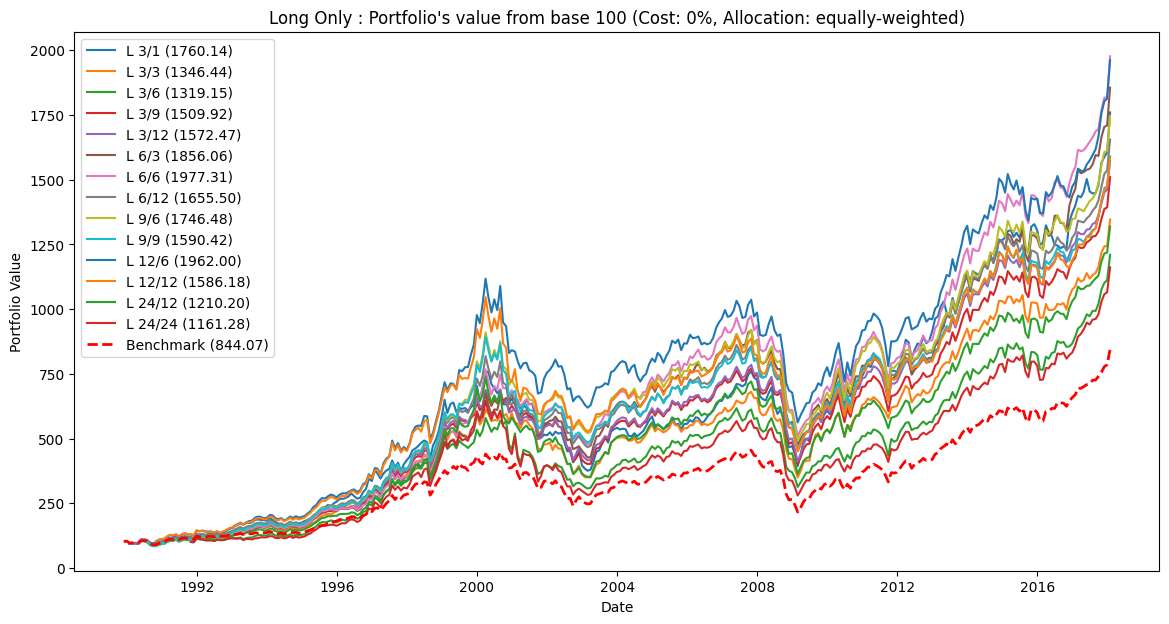

In [14]:
nb_long = 5
nb_short = 5
long_fees=0
short_fees=0
initial_capital = 1e8
long_Q = 1.
short_Q = 0.
Ticker = "L"
title_plot = "Long Only"
cost_type = "0%"
allocation_type = "equally-weighted"
title_HTML = """<strong>Long Only strategy :</strong><br><br>
<span style="font-weight: normal;">1. Observation period / Holding period in months</span><br>
<span style="font-weight: normal;">2. Top 5 pfs for the Long portfolios</span><br>
<span style="font-weight: normal;">3. Costs = 0%</span><br>
<span style="font-weight: normal;">4. Allocation : Equally weighted</span>"""
plot_results (nb_long,nb_short,long_fees,short_fees,initial_capital,long_Q,short_Q,transaction_costs_linear,
                  get_ponderation_equally_weighted,Ticker, title_plot,cost_type,allocation_type,title_HTML, plot_details = False)

**4.1.2. Increase the winners**

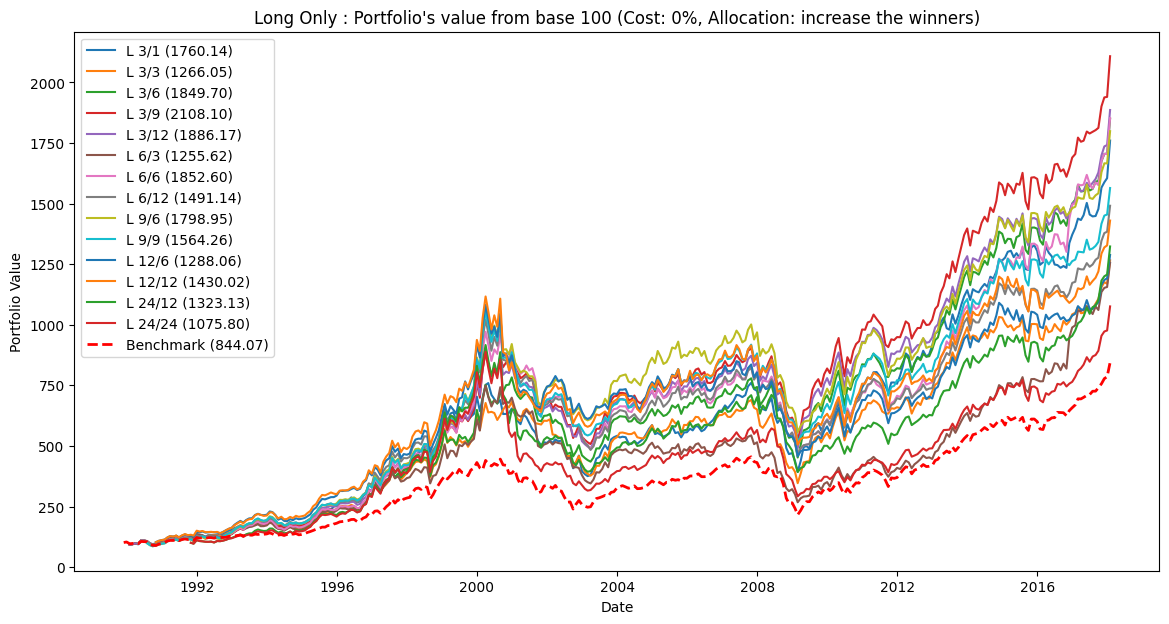

In [15]:
nb_long = 5
nb_short = 5
long_fees=0
short_fees=0
initial_capital = 1e8
long_Q = 1.
short_Q = 0.
Ticker = "L"
title_plot = "Long Only"
cost_type = "0%"
allocation_type = "increase the winners"
title_HTML = """<strong>Long Only strategy :</strong><br><br>
<span style="font-weight: normal;">1. Observation period / Holding period in months</span><br>
<span style="font-weight: normal;">2. Top 5 pfs for the Long portfolios</span><br>
<span style="font-weight: normal;">3. Costs = 0%</span><br>
<span style="font-weight: normal;">4. Allocation : Increase the winners</span>"""
plot_results (nb_long,nb_short,long_fees,short_fees,initial_capital,long_Q,short_Q,transaction_costs_linear,
                  get_ponderation_increase_the_winners,Ticker, title_plot,cost_type,allocation_type,title_HTML, plot_details = False)

**4.1.3. Increase the recent winners**

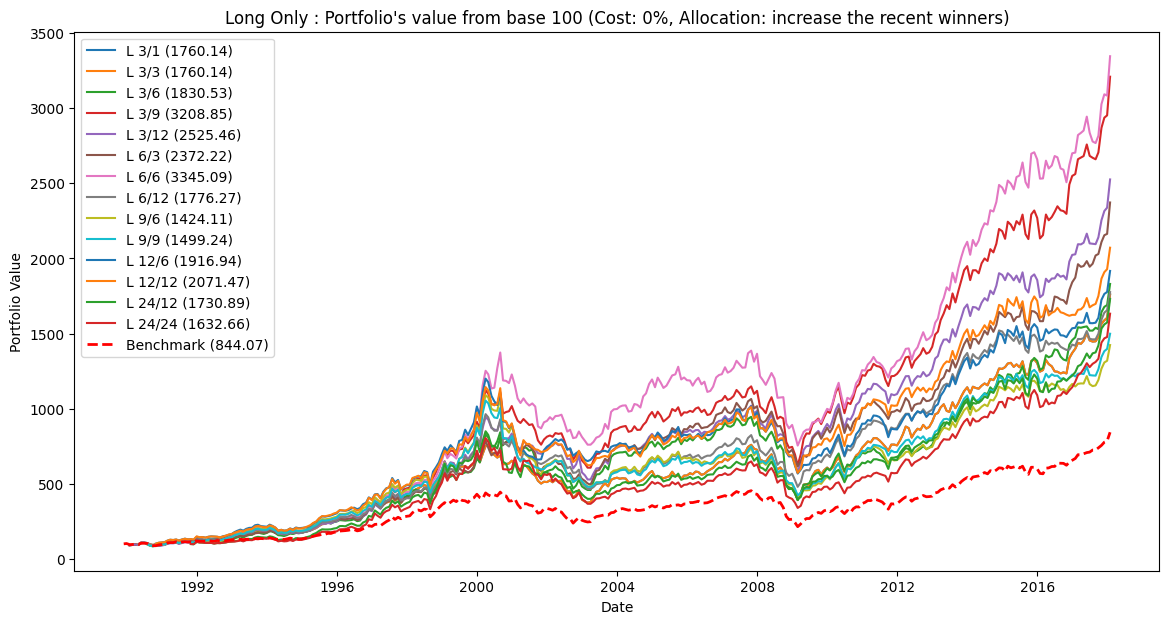

In [16]:
nb_long = 5
nb_short = 5
long_fees=0
short_fees=0
initial_capital = 1e8
long_Q = 1.
short_Q = 0.
Ticker = "L"
title_plot = "Long Only"
cost_type = "0%"
allocation_type = "increase the recent winners"
title_HTML = """<strong>Long Only strategy :</strong><br><br>
<span style="font-weight: normal;">1. Observation period / Holding period in months</span><br>
<span style="font-weight: normal;">2. Top 5 pfs for the Long portfolios</span><br>
<span style="font-weight: normal;">3. Costs = 0%</span><br>
<span style="font-weight: normal;">4. Allocation : Increase the recent winners</span>"""
plot_results (nb_long,nb_short,long_fees,short_fees,initial_capital,long_Q,short_Q,transaction_costs_linear,
                  get_ponderation_increase_the_recent_winners,Ticker, title_plot,cost_type,allocation_type,title_HTML, plot_details = False)

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">4.2. With proportionnal fees </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

**4.2.1. Equally weighted**

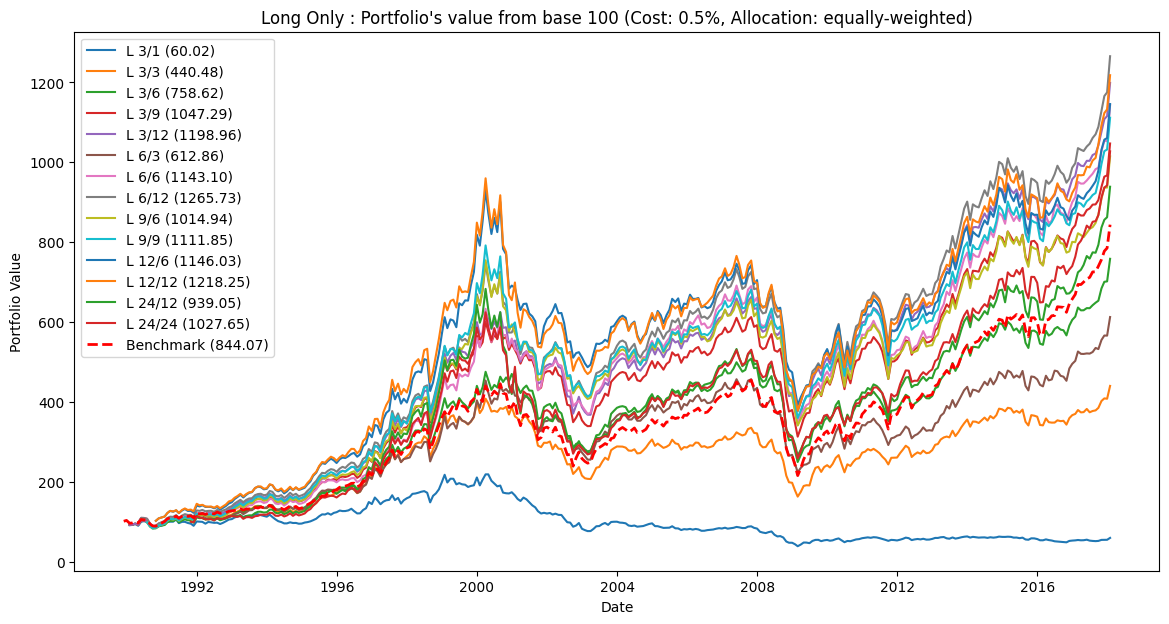

In [17]:
nb_long = 5
nb_short = 5
long_fees=0.005
short_fees=0.
initial_capital = 1e8
long_Q = 1.
short_Q = 0.
Ticker = "L"
title_plot = "Long Only"
cost_type = "0.5%"
allocation_type = "equally-weighted"
title_HTML = """<strong>Long Only strategy :</strong><br><br>
<span style="font-weight: normal;">1. Observation period / Holding period in months</span><br>
<span style="font-weight: normal;">2. Top 5 pfs for the Long portfolios</span><br>
<span style="font-weight: normal;">3. Costs = 0.5%</span><br>
<span style="font-weight: normal;">4. Allocation : Equally weighted</span>"""
plot_results (nb_long,nb_short,long_fees,short_fees,initial_capital,long_Q,short_Q,transaction_costs_linear,
                  get_ponderation_equally_weighted,Ticker, title_plot,cost_type,allocation_type,title_HTML, plot_details = False)

**4.2.2. Increase the winners**

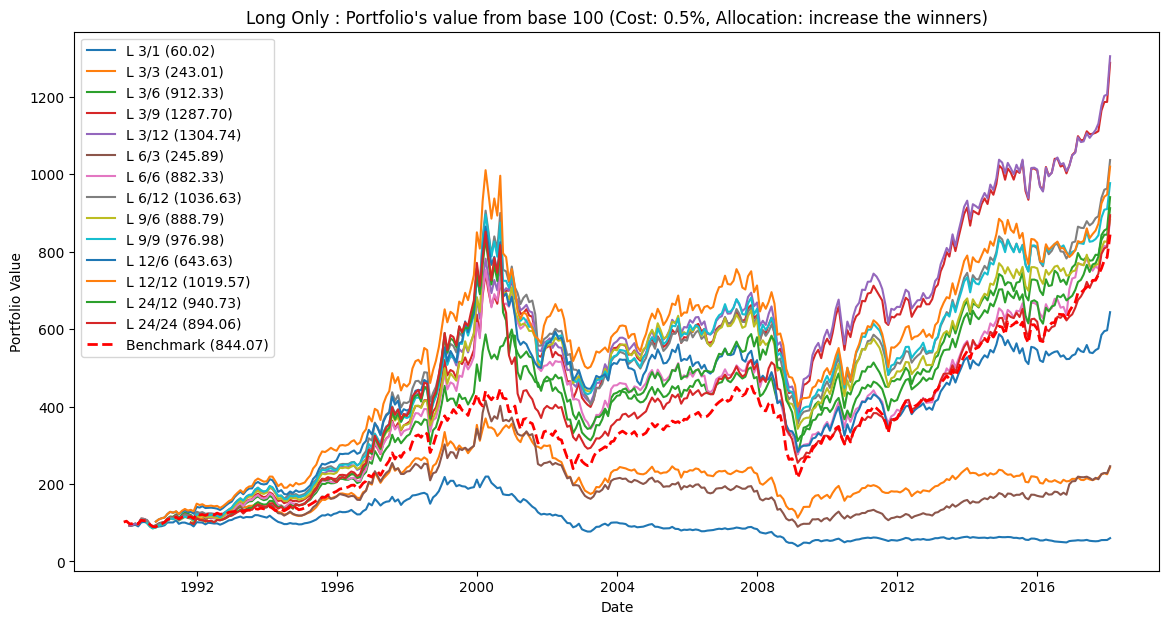

In [18]:
nb_long = 5
nb_short = 5
long_fees=0.005
short_fees=0
initial_capital = 1e8
long_Q = 1.
short_Q = 0.
Ticker = "L"
title_plot = "Long Only"
cost_type = "0.5%"
allocation_type = "increase the winners"
title_HTML = """<strong>Long Only strategy :</strong><br><br>
<span style="font-weight: normal;">1. Observation period / Holding period in months</span><br>
<span style="font-weight: normal;">2. Top 5 pfs for the Long portfolios</span><br>
<span style="font-weight: normal;">3. Costs = 0.5%</span><br>
<span style="font-weight: normal;">4. Allocation : Increase the winners</span>"""
plot_results (nb_long,nb_short,long_fees,short_fees,initial_capital,long_Q,short_Q,transaction_costs_linear,
                  get_ponderation_increase_the_winners,Ticker, title_plot,cost_type,allocation_type,title_HTML, plot_details = False)

**4.2.3. Increase the recent winners**

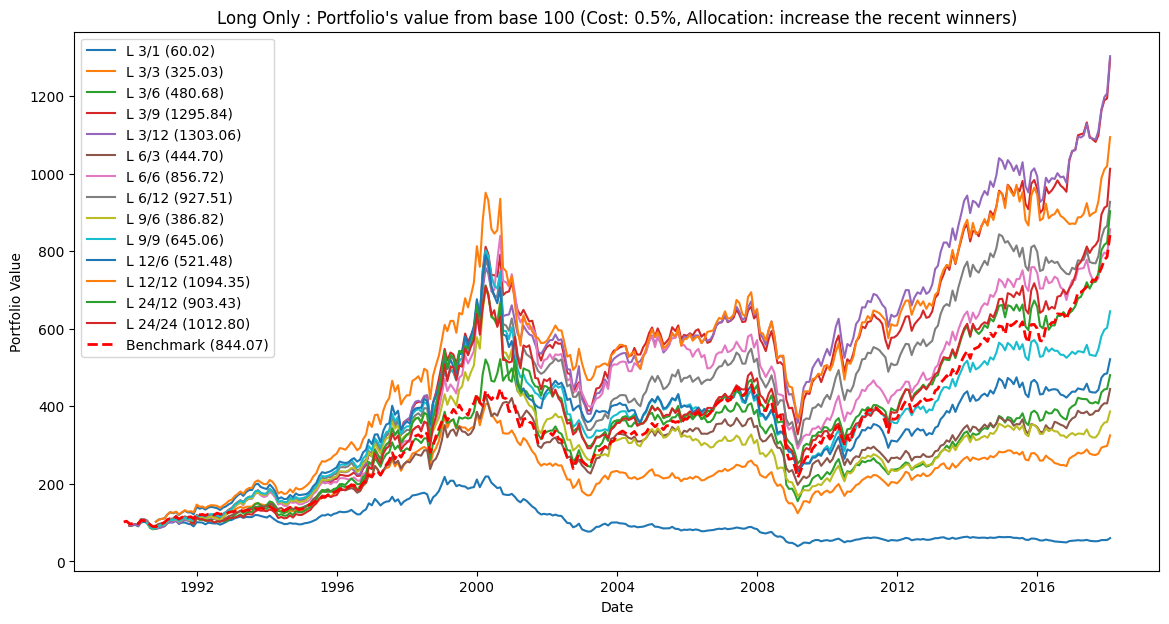

In [19]:
nb_long = 5
nb_short = 5
long_fees=0.005
short_fees=0
initial_capital = 1e8
long_Q = 1.
short_Q = 0.
Ticker = "L"
title_plot = "Long Only"
cost_type = "0.5%"
allocation_type = "increase the recent winners"
title_HTML = """<strong>Long Only strategy :</strong><br><br>
<span style="font-weight: normal;">1. Observation period / Holding period in months</span><br>
<span style="font-weight: normal;">2. Top 5 pfs for the Long portfolios</span><br>
<span style="font-weight: normal;">3. Costs = 0.5%</span><br>
<span style="font-weight: normal;">4. Allocation : Increase the recent winners</span>"""
plot_results (nb_long,nb_short,long_fees,short_fees,initial_capital,long_Q,short_Q,transaction_costs_linear,
                  get_ponderation_increase_the_recent_winners,Ticker, title_plot,cost_type,allocation_type,title_HTML, plot_details = False)

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">4.3. Progressive fee structure </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

**4.3.1. Equally weighted**

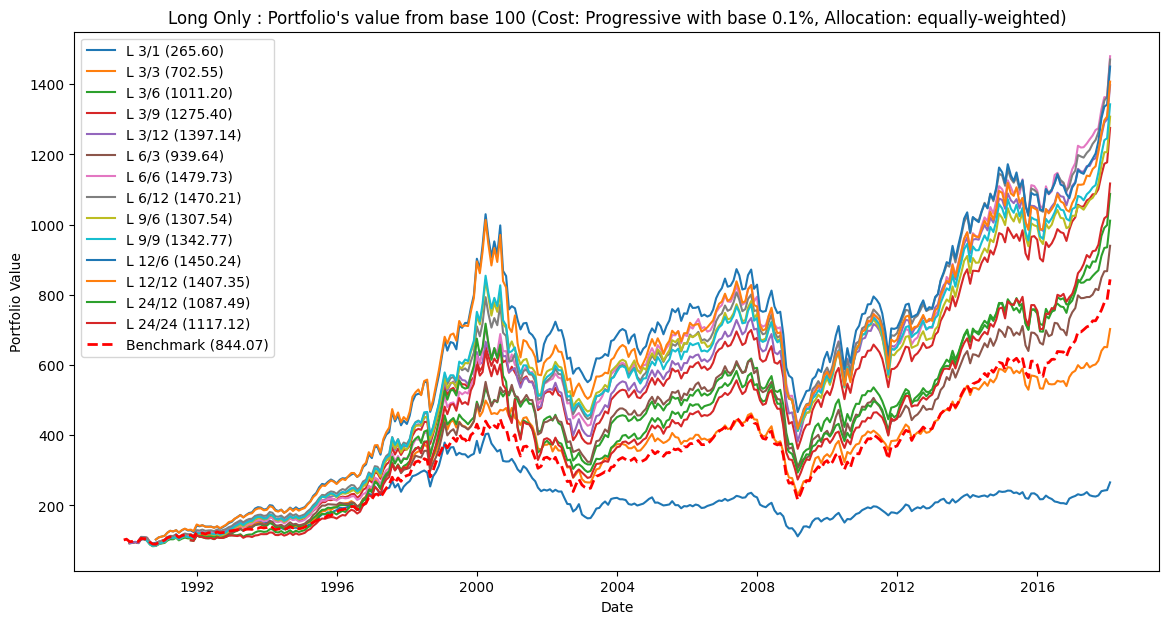

In [20]:
nb_long = 5
nb_short = 5
long_fees=0.001
short_fees=0.
initial_capital = 1e8
long_Q = 1.
short_Q = 0.
Ticker = "L"
title_plot = "Long Only"
cost_type = "Progressive with base 0.1%"
allocation_type = "equally-weighted"
title_HTML = """<strong>Long Only strategy :</strong><br><br>
<span style="font-weight: normal;">1. Observation period / Holding period in months</span><br>
<span style="font-weight: normal;">2. Top 5 pfs for the Long portfolios</span><br>
<span style="font-weight: normal;">3. Costs = Progressive a floor at 0.1%</span><br>
<span style="font-weight: normal;">4. Allocation : Equally weighted</span>"""
plot_results (nb_long,nb_short,long_fees,short_fees,initial_capital,long_Q,short_Q,transaction_costs_dynamic,
                  get_ponderation_equally_weighted,Ticker, title_plot,cost_type,allocation_type,title_HTML, plot_details = False)

**4.3.2. Increase the winners**

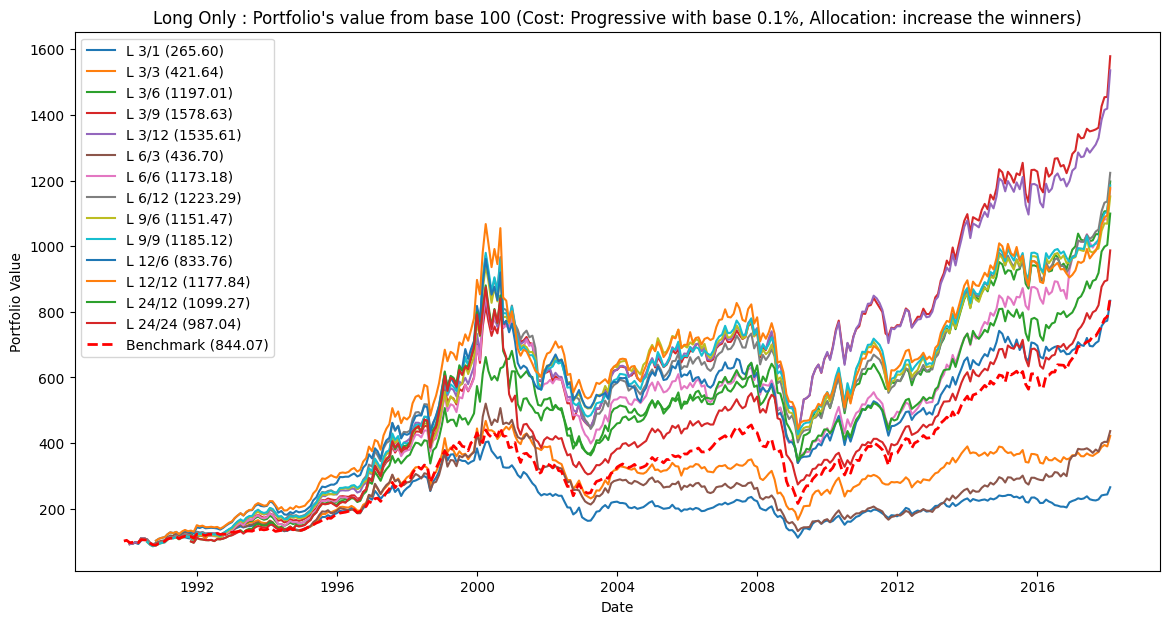

In [21]:
nb_long = 5
nb_short = 5
long_fees=0.001
short_fees=0
initial_capital = 1e8
long_Q = 1.
short_Q = 0.
Ticker = "L"
title_plot = "Long Only"
cost_type = "Progressive with base 0.1%"
allocation_type = "increase the winners"
title_HTML = """<strong>Long Only strategy :</strong><br><br>
<span style="font-weight: normal;">1. Observation period / Holding period in months</span><br>
<span style="font-weight: normal;">2. Top 5 pfs for the Long portfolios</span><br>
<span style="font-weight: normal;">3. Costs = Progressive with a floor at 0.1%</span><br>
<span style="font-weight: normal;">4. Allocation : Increase the winners</span>"""
plot_results (nb_long,nb_short,long_fees,short_fees,initial_capital,long_Q,short_Q,transaction_costs_dynamic,
                  get_ponderation_increase_the_winners,Ticker, title_plot,cost_type,allocation_type,title_HTML, plot_details = False)

**4.3.3. Increase the recent winners**

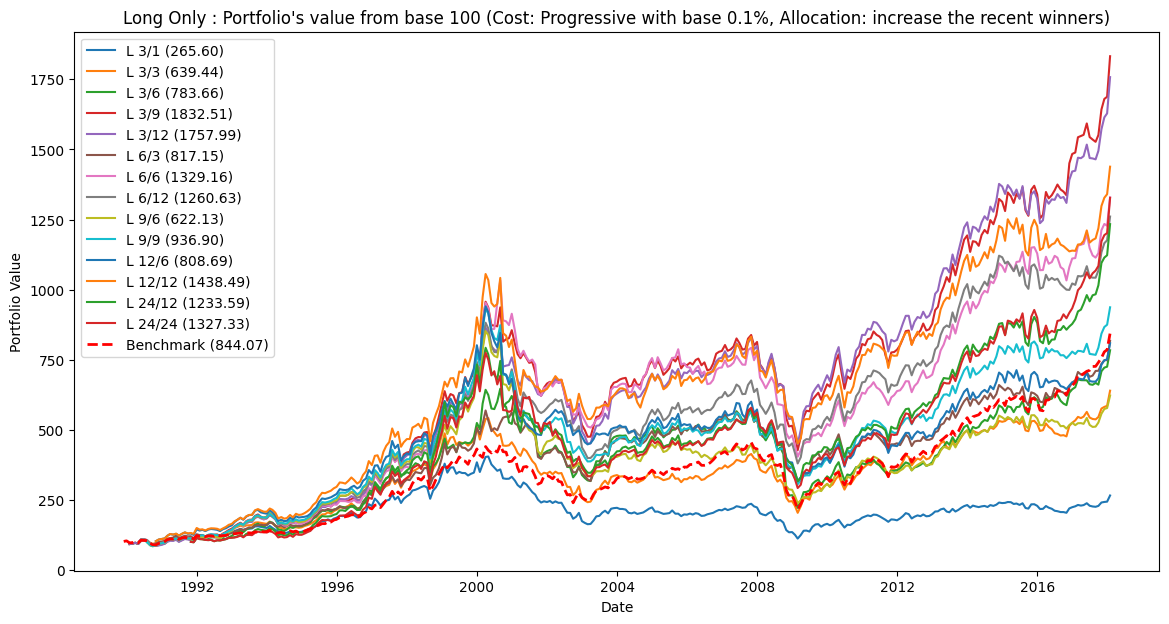

In [22]:
nb_long = 5
nb_short = 5
long_fees=0.001
short_fees=0
initial_capital = 1e8
long_Q = 1.
short_Q = 0.
Ticker = "L"
title_plot = "Long Only"
cost_type = "Progressive with base 0.1%"
allocation_type = "increase the recent winners"
title_HTML = """<strong>Long Only strategy :</strong><br><br>
<span style="font-weight: normal;">1. Observation period / Holding period in months</span><br>
<span style="font-weight: normal;">2. Top 5 pfs for the Long portfolios</span><br>
<span style="font-weight: normal;">3. Costs = Progressive with a floor at 0.1%</span><br>
<span style="font-weight: normal;">4. Allocation : Increase the recent winners</span>"""
plot_results (nb_long,nb_short,long_fees,short_fees,initial_capital,long_Q,short_Q,transaction_costs_dynamic,
                  get_ponderation_increase_the_recent_winners,Ticker, title_plot,cost_type,allocation_type,title_HTML, plot_details = False)

<header style="background-color: rgb(0, 62, 92); color: white; margin-top: 20px; padding:20px; ">
  <p style=" text-align: center; font-size: 32px;">   
    <p style=" text-align: center; font-size: 33px;"><strong> 5. Long-Short strategies<strong></p>
</header>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">5.1. Without fees </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

**5.1.1. Equally weighted**

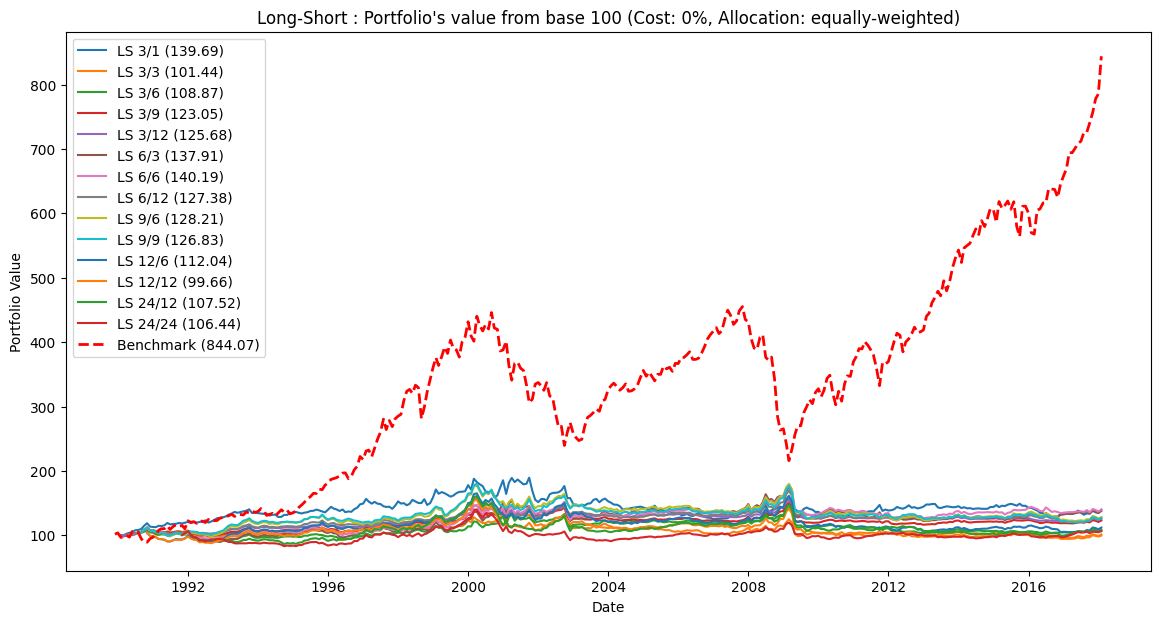

In [23]:
nb_long = 5
nb_short = 3
long_fees=0
short_fees=0
initial_capital = 1e8
long_Q = 0.5
short_Q = 0.5
Ticker = "LS"
title_plot = "Long-Short"
cost_type = "0%"
allocation_type = "equally-weighted"
title_HTML = """<strong>Long-Short strategy :</strong><br><br>
<span style="font-weight: normal;">1. Observation period / Holding period in months</span><br>
<span style="font-weight: normal;">2. Top 5 pfs for the Long portfolios, Top 3 for the Short portfolios</span><br>
<span style="font-weight: normal;">3. Costs = 0%</span><br>
<span style="font-weight: normal;">4. Allocation : Equally weighted</span>"""
plot_results (nb_long,nb_short,long_fees,short_fees,initial_capital,long_Q,short_Q,transaction_costs_linear,
                  get_ponderation_equally_weighted,Ticker, title_plot,cost_type,allocation_type,title_HTML, plot_details = False)

**5.1.2. Increase the winners**

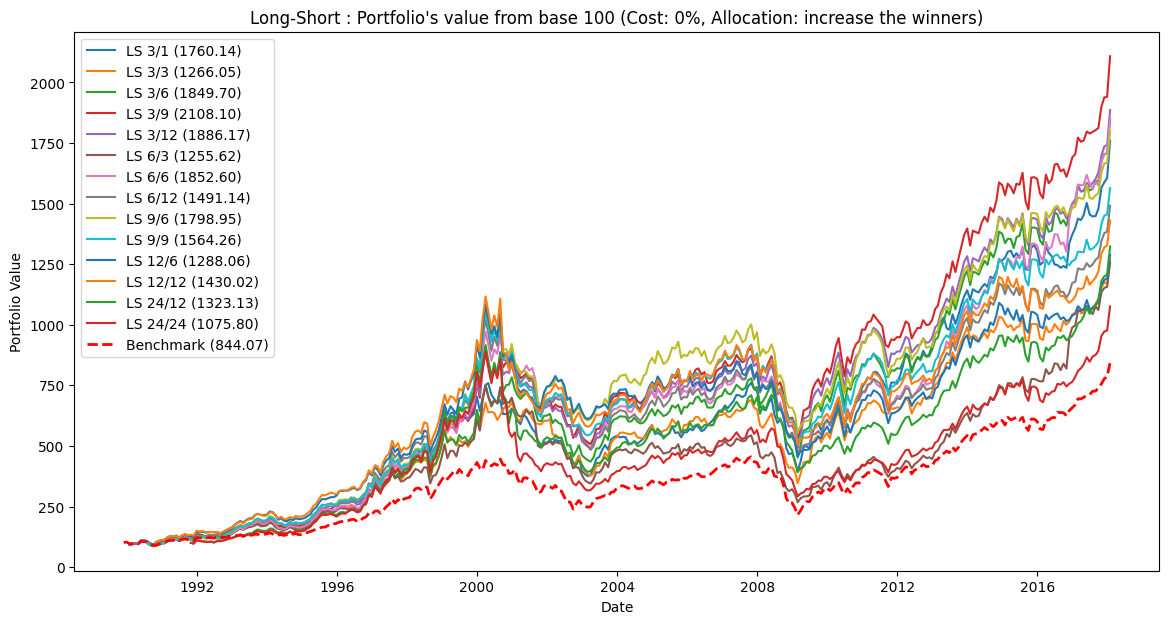

In [24]:
nb_long = 5
nb_short = 3
long_fees=0
short_fees=0
initial_capital = 1e8
long_Q = 1.
short_Q = 0.
Ticker = "LS"
title_plot = "Long-Short"
cost_type = "0%"
allocation_type = "increase the winners"
title_HTML = """<strong>Long-Short strategy :</strong><br><br>
<span style="font-weight: normal;">1. Observation period / Holding period in months</span><br>
<span style="font-weight: normal;">2. Top 5 pfs for the Long portfolios, Top 3 for the Short portfolios</span><br>
<span style="font-weight: normal;">3. Costs = 0%</span><br>
<span style="font-weight: normal;">4. Allocation : Increase the winners</span>"""
plot_results (nb_long,nb_short,long_fees,short_fees,initial_capital,long_Q,short_Q,transaction_costs_linear,
                  get_ponderation_increase_the_winners,Ticker, title_plot,cost_type,allocation_type,title_HTML, plot_details = False)

**5.1.3. Fully directionnal**

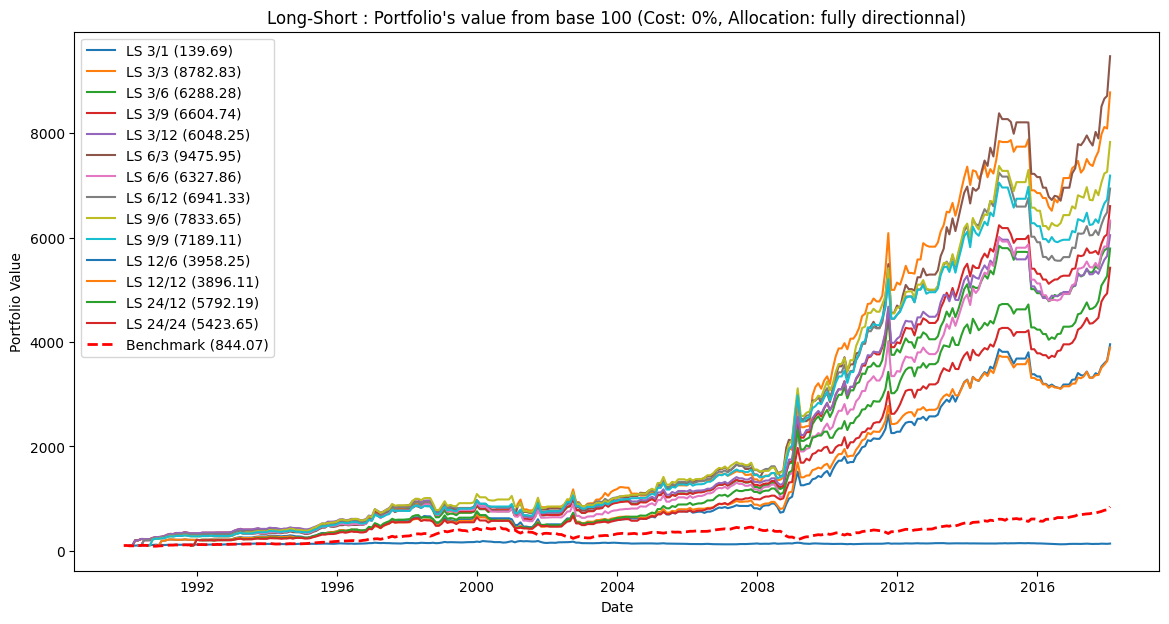

In [25]:
nb_long = 5
nb_short = 3
long_fees=0
short_fees=0
initial_capital = 1e8
long_Q = 1.
short_Q = 0.
Ticker = "LS"
title_plot = "Long-Short"
cost_type = "0%"
allocation_type = "fully directionnal"
title_HTML = """<strong>Long-Short strategy :</strong><br><br>
<span style="font-weight: normal;">1. Observation period / Holding period in months</span><br>
<span style="font-weight: normal;">2. Top 5 pfs for the Long portfolios, Top 3 for the Short portfolios</span><br>
<span style="font-weight: normal;">3. Costs = 0%</span><br>
<span style="font-weight: normal;">4. Allocation : Fully directionnal</span>"""
plot_results (nb_long,nb_short,long_fees,short_fees,initial_capital,long_Q,short_Q,transaction_costs_linear,
                  get_ponderation_total_directional,Ticker, title_plot,cost_type,allocation_type,title_HTML, plot_details = False)

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">5.2. With proportionnal fees </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

**5.2.1. Equally weighted**

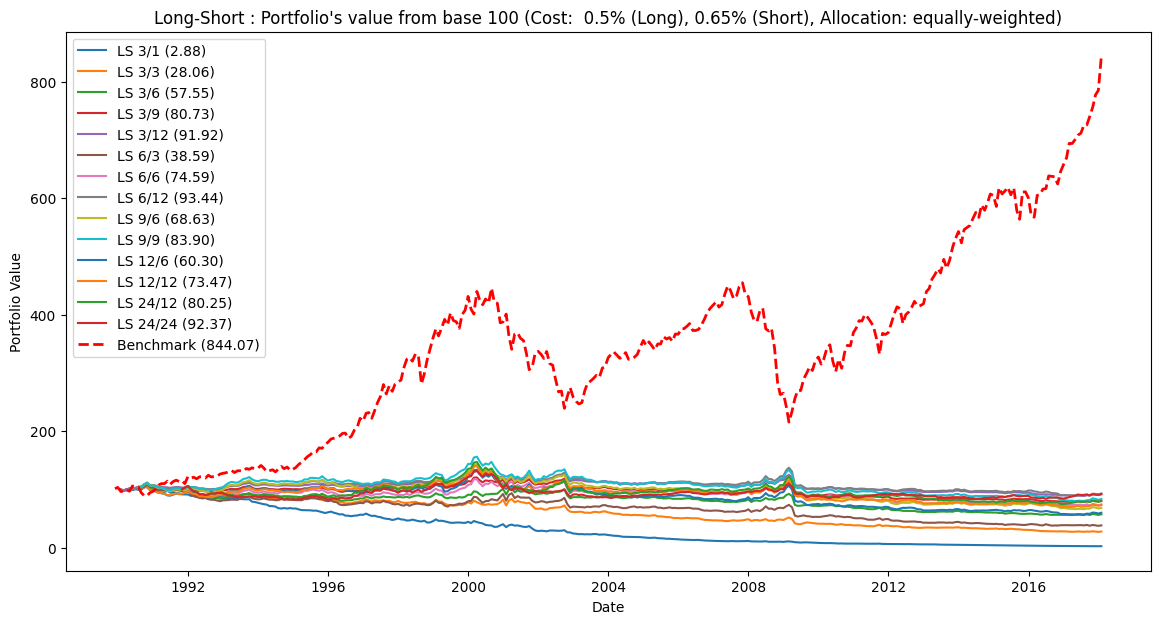

In [26]:
nb_long = 5
nb_short = 3
long_fees=0.005
short_fees=0.0065
initial_capital = 1e8
long_Q = 0.5
short_Q = 0.5
Ticker = "LS"
title_plot = "Long-Short"
cost_type = " 0.5% (Long), 0.65% (Short)"
allocation_type = "equally-weighted"
title_HTML = """<strong>Long-Short strategy :</strong><br><br>
<span style="font-weight: normal;">1. Observation period / Holding period in months</span><br>
<span style="font-weight: normal;">2. Top 5 pfs for the Long portfolios, Top 3 for the Short portfolios</span><br>
<span style="font-weight: normal;">3. Costs = 0.5% (Long), 0.65% (Short)%</span><br>
<span style="font-weight: normal;">4. Allocation : Equally weighted</span>"""
plot_results (nb_long,nb_short,long_fees,short_fees,initial_capital,long_Q,short_Q,transaction_costs_linear,
                  get_ponderation_equally_weighted,Ticker, title_plot,cost_type,allocation_type,title_HTML, plot_details = False)

**5.2.2. Increase the winners**

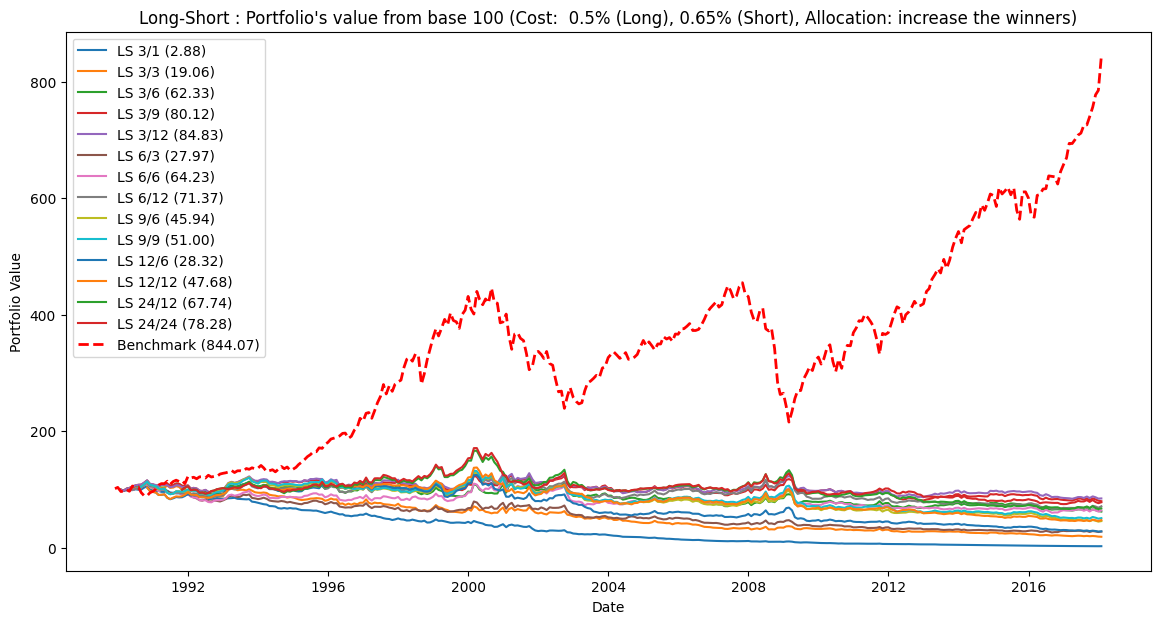

In [27]:
nb_long = 5
nb_short = 3
long_fees=0.005
short_fees=0.0065
initial_capital = 1e8
long_Q = 0.5
short_Q = 0.5
Ticker = "LS"
title_plot = "Long-Short"
cost_type = " 0.5% (Long), 0.65% (Short)"
allocation_type = "increase the winners"
title_HTML = """<strong>Long-Short strategy :</strong><br><br>
<span style="font-weight: normal;">1. Observation period / Holding period in months</span><br>
<span style="font-weight: normal;">2. Top 5 pfs for the Long portfolios, Top 3 for the Short portfolios</span><br>
<span style="font-weight: normal;">3. Costs = 0.5% (Long), 0.65% (Short)%</span><br>
<span style="font-weight: normal;">4. Allocation : Increase the winners</span>"""
plot_results (nb_long,nb_short,long_fees,short_fees,initial_capital,long_Q,short_Q,transaction_costs_linear,
                  get_ponderation_increase_the_winners,Ticker, title_plot,cost_type,allocation_type,title_HTML, plot_details = False)

**5.2.3. Fully directionnal**

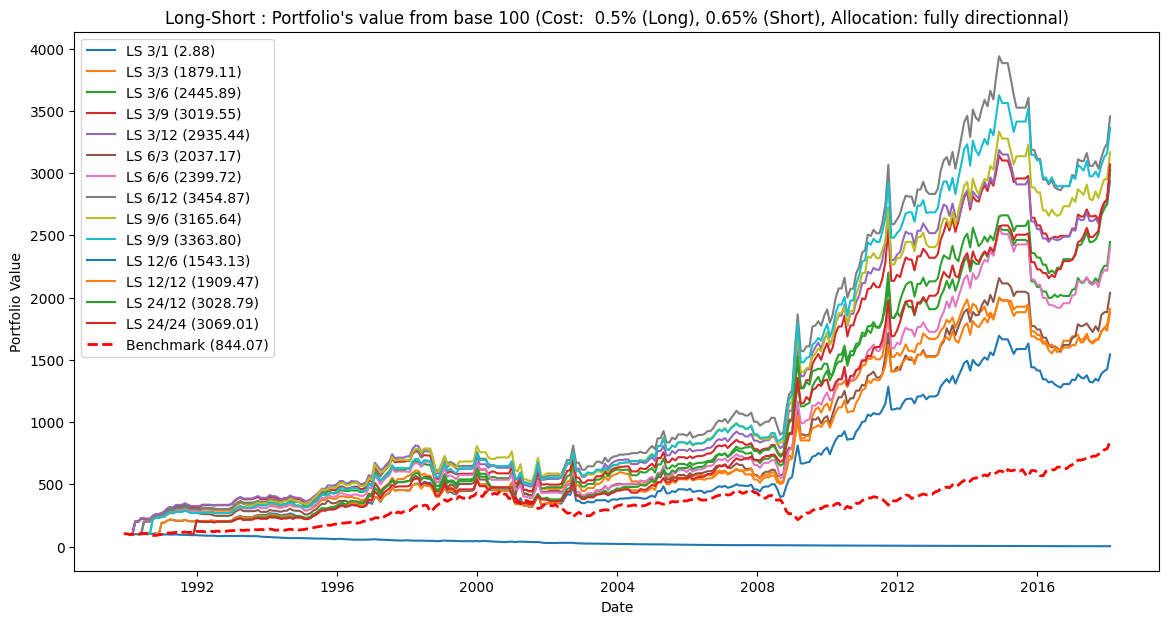

In [28]:
nb_long = 5
nb_short = 3
long_fees=0.005
short_fees=0.0065
initial_capital = 1e8
long_Q = 1.
short_Q = 0.
Ticker = "LS"
title_plot = "Long-Short"
cost_type = " 0.5% (Long), 0.65% (Short)"
allocation_type = "fully directionnal"
title_HTML = """<strong>Long-Short strategy :</strong><br><br>
<span style="font-weight: normal;">1. Observation period / Holding period in months</span><br>
<span style="font-weight: normal;">2. Top 5 pfs for the Long portfolios, Top 3 for the Short portfolios</span><br>
<span style="font-weight: normal;">3. Costs = 0.5% (Long), 0.65% (Short)</span><br>
<span style="font-weight: normal;">4. Allocation : Fully directionnal</span>"""
plot_results (nb_long,nb_short,long_fees,short_fees,initial_capital,long_Q,short_Q,transaction_costs_linear,
                  get_ponderation_total_directional,Ticker, title_plot,cost_type,allocation_type,title_HTML, plot_details = False)

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

<a id="fbm"></a><h1 style="text-align:center;">5.3. Progressive fee structure </h1>

<div style="background-color: rgb(0, 62, 92); height:10px; margin-top:25px; margin-bottom:25px;"></div>

**5.3.1. Equally weighted**

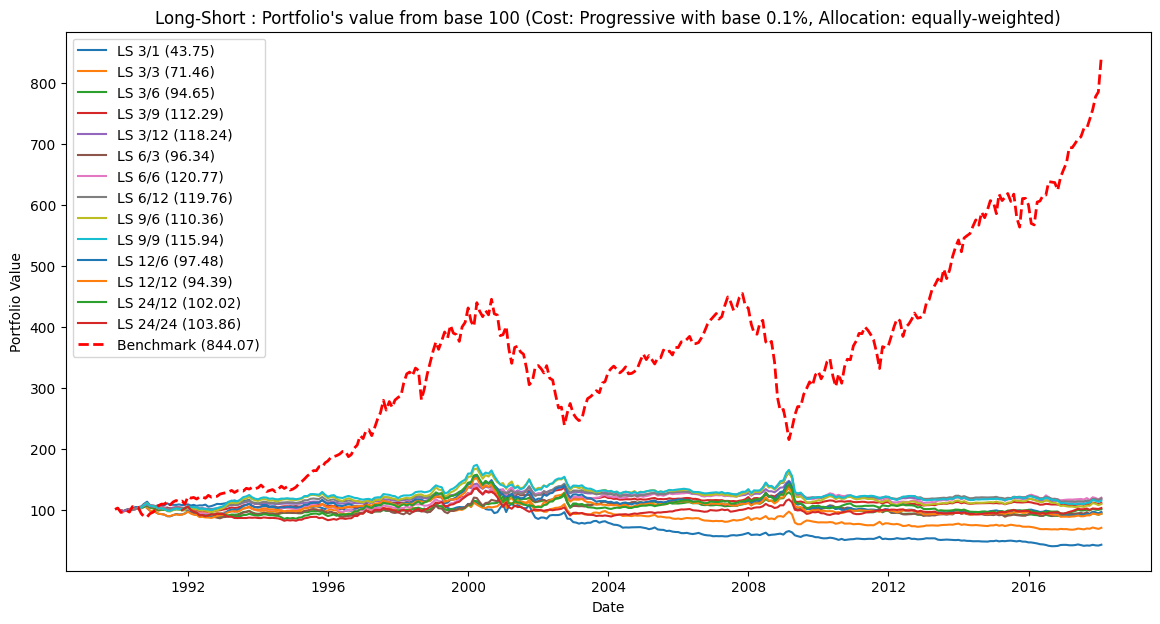

In [29]:
nb_long = 5
nb_short = 3
long_fees=0.001
short_fees=0.001
initial_capital = 1e8
long_Q = 0.5
short_Q = 0.5
Ticker = "LS"
title_plot = "Long-Short"
cost_type = "Progressive with base 0.1%"
allocation_type = "equally-weighted"
title_HTML = """<strong>Long-Short strategy :</strong><br><br>
<span style="font-weight: normal;">1. Observation period / Holding period in months</span><br>
<span style="font-weight: normal;">2. Top 5 pfs for the Long portfolios, Top 3 for the Short portfolios</span><br>
<span style="font-weight: normal;">3. Costs = Progressive with a floor at 0.1%</span><br>
<span style="font-weight: normal;">4. Allocation : Equally weighted</span>"""
plot_results (nb_long,nb_short,long_fees,short_fees,initial_capital,long_Q,short_Q,transaction_costs_dynamic,
                  get_ponderation_equally_weighted,Ticker, title_plot,cost_type,allocation_type,title_HTML, plot_details = False)

**5.3.2. Increase the winners**

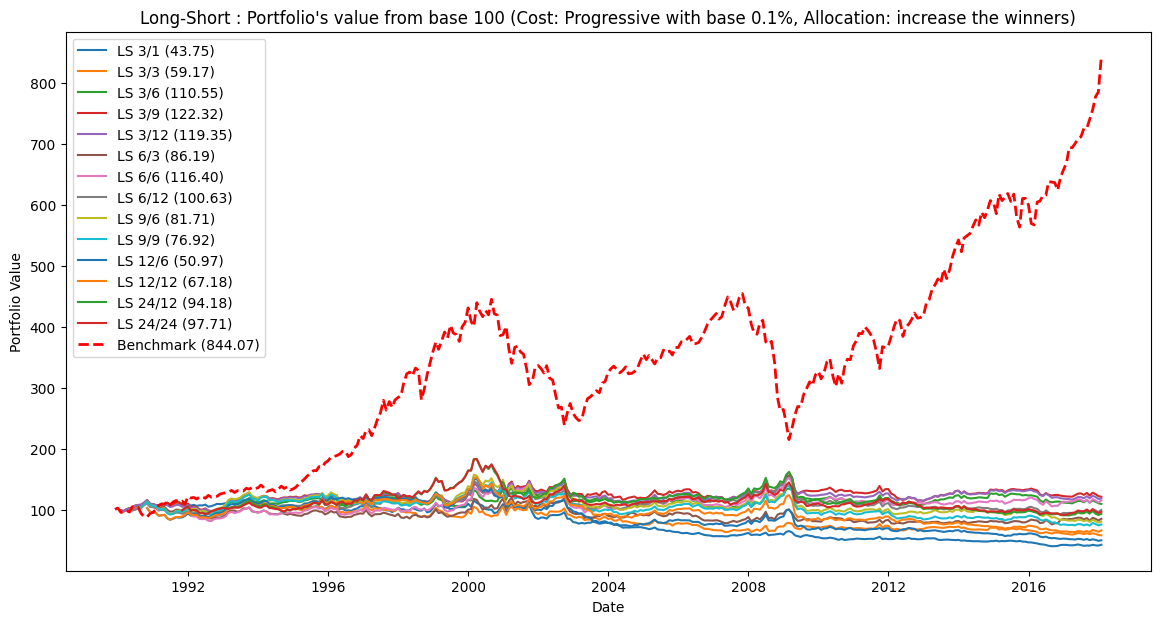

In [30]:
nb_long = 5
nb_short = 3
long_fees=0.001
short_fees=0.001
initial_capital = 1e8
long_Q = 0.5
short_Q = 0.5
Ticker = "LS"
title_plot = "Long-Short"
cost_type = "Progressive with base 0.1%"
allocation_type = "increase the winners"
title_HTML = """<strong>Long-Short strategy :</strong><br><br>
<span style="font-weight: normal;">1. Observation period / Holding period in months</span><br>
<span style="font-weight: normal;">2. Top 5 pfs for the Long portfolios, Top 3 for the Short portfolios</span><br>
<span style="font-weight: normal;">3. Costs = Progressive with a floor at 0.1%</span><br>
<span style="font-weight: normal;">4. Allocation : Increase the winners</span>"""
plot_results (nb_long,nb_short,long_fees,short_fees,initial_capital,long_Q,short_Q,transaction_costs_dynamic,
                  get_ponderation_increase_the_winners,Ticker, title_plot,cost_type,allocation_type,title_HTML, plot_details = False)

**5.3.3. Fully directionnal**

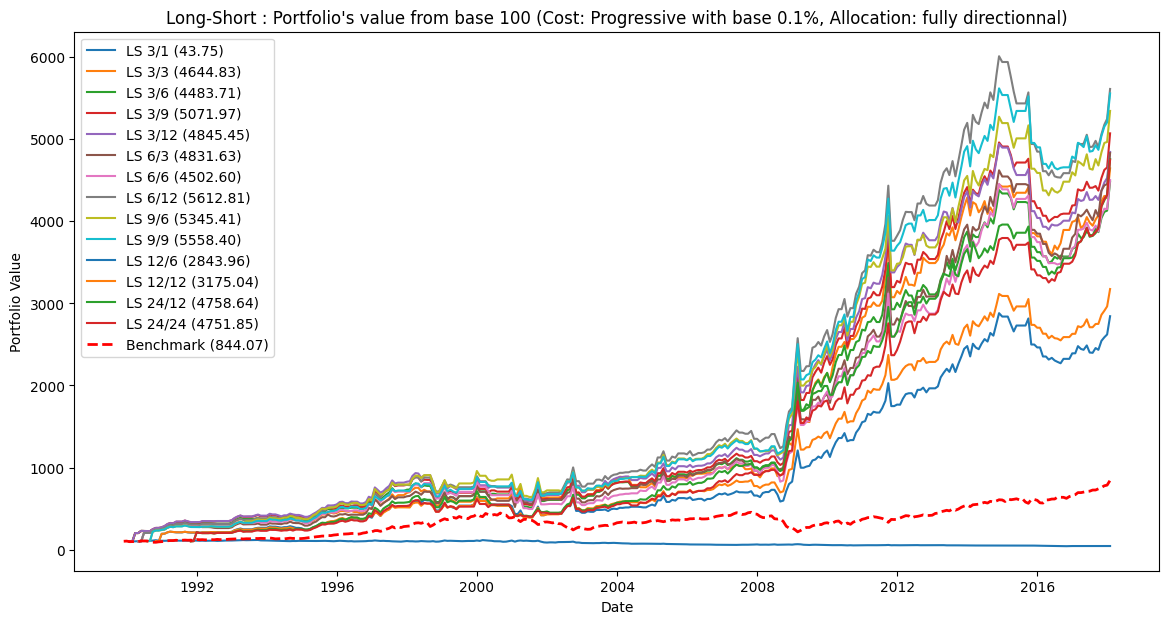

In [31]:
nb_long = 5
nb_short = 3
long_fees=0.001
short_fees=0.001
initial_capital = 1e8
long_Q = 0.5
short_Q = 0.5
Ticker = "LS"
title_plot = "Long-Short"
cost_type = "Progressive with base 0.1%"
allocation_type = "fully directionnal"
title_HTML = """<strong>Long-Short strategy :</strong><br><br>
<span style="font-weight: normal;">1. Observation period / Holding period in months</span><br>
<span style="font-weight: normal;">2. Top 5 pfs for the Long portfolios, Top 3 for the Short portfolios</span><br>
<span style="font-weight: normal;">3. Costs = Progressive with a floor at 0.1%</span><br>
<span style="font-weight: normal;">4. Allocation : Fully directionnal</span>"""
plot_results (nb_long,nb_short,long_fees,short_fees,initial_capital,long_Q,short_Q,transaction_costs_dynamic,
                  get_ponderation_total_directional,Ticker, title_plot,cost_type,allocation_type,title_HTML, plot_details = False)